In [1]:
# ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô GEE
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

ee.Authenticate()
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [2]:
import folium

# ‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà‡∏®‡∏∂‡∏Å‡∏©‡∏≤ ‡πÄ‡∏ä‡∏µ‡∏¢‡∏á‡πÉ‡∏´‡∏°‡πà
siteName = 'Mae Hong Son'
# siteName = 'Chiang Mai'
# siteName = 'Nan'
# siteName = 'Uttaradit'
study_area = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', 'Thailand')).filter(ee.Filter.eq('ADM1_NAME', siteName))

# config figure height
f = folium.Figure(height=300)

# add map to figure
m = folium.Map(location=[18.9, 99.0], zoom_start=7).add_to(f)

# add study area to map
folium.GeoJson(study_area.getInfo()).add_to(m)

m

In [3]:
# Comprehensive Model Evaluation with Baseline Models and Prediction Intervals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

try:
    import statsmodels.api as sm
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.tsa.stattools import adfuller
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("Warning: statsmodels ‡πÑ‡∏°‡πà‡∏û‡∏£‡πâ‡∏≠‡∏°‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô ‡∏ö‡∏≤‡∏á baseline models ‡∏à‡∏∞‡πÑ‡∏°‡πà‡∏ó‡∏≥‡∏á‡∏≤‡∏ô")

try:
    import pmdarima as pm
    PMDARIMA_AVAILABLE = True
except ImportError:
    PMDARIMA_AVAILABLE = False
    print("Warning: pmdarima ‡πÑ‡∏°‡πà‡∏û‡∏£‡πâ‡∏≠‡∏°‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô Auto-ARIMA ‡∏à‡∏∞‡πÑ‡∏°‡πà‡∏ó‡∏≥‡∏á‡∏≤‡∏ô")

def get_monthly_hotspots(start_date, end_date, study_area, temp_min=310, temp_max=320, all_hotspots=False):
    """
    ‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• hotspot ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏î‡πâ‡∏ß‡∏¢‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á‡∏≠‡∏∏‡∏ì‡∏´‡∏†‡∏π‡∏°‡∏¥ T21 ‡πÉ‡∏ô‡∏ä‡πà‡∏ß‡∏á‡∏ó‡∏µ‡πà‡∏Å‡∏≥‡∏´‡∏ô‡∏î
    
    Parameters:
    - start_date, end_date: ‡∏ä‡πà‡∏ß‡∏á‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà
    - study_area: ‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà‡∏®‡∏∂‡∏Å‡∏©‡∏≤
    - temp_min: ‡∏≠‡∏∏‡∏ì‡∏´‡∏†‡∏π‡∏°‡∏¥‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î (Kelvin) - default 310
    - temp_max: ‡∏≠‡∏∏‡∏ì‡∏´‡∏†‡∏π‡∏°‡∏¥‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î (Kelvin) - default 320
    - all_hotspots: ‡∏ñ‡πâ‡∏≤ True ‡πÉ‡∏ä‡πâ‡πÄ‡∏Å‡∏ì‡∏ë‡πå T21 > 0 ‡πÅ‡∏ó‡∏ô‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á min-max
    """
    try:
        # ‡πÄ‡∏£‡∏µ‡∏¢‡∏Å‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• FIRMS
        firms = ee.ImageCollection('FIRMS') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)

        # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
        size = firms.size().getInfo()
        print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏†‡∏≤‡∏û FIRMS ‡∏î‡∏¥‡∏ö: {size}")
        if size == 0:
            print("‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• FIRMS ‡πÉ‡∏ô‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà‡∏®‡∏∂‡∏Å‡∏©‡∏≤")
            return None

        if all_hotspots:
            print("‡πÉ‡∏ä‡πâ‡πÄ‡∏Å‡∏ì‡∏ë‡πå: ‡∏ó‡∏∏‡∏Å‡∏à‡∏∏‡∏î‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô (T21 > 0)")
        else:
            print(f"‡πÉ‡∏ä‡πâ‡πÄ‡∏Å‡∏ì‡∏ë‡πå‡∏≠‡∏∏‡∏ì‡∏´‡∏†‡∏π‡∏°‡∏¥: {temp_min}K ‚â§ T21 < {temp_max}K")

        # Apply temperature filter for T21
        def convert_to_filtered_presence(image):
            t21 = image.select('T21')
            if all_hotspots:
                hotspot_presence = t21.gt(0).rename('hotspot_presence')
            else:
                hotspot_presence = t21.gte(temp_min).And(t21.lt(temp_max)).rename('hotspot_presence')
            return image.addBands(hotspot_presence).copyProperties(image, ['system:time_start'])

        firms_with_presence = firms.map(convert_to_filtered_presence)

        # ‡∏£‡∏ß‡∏° hotspot ‡πÄ‡∏õ‡πá‡∏ô‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
        def create_monthly_hotspot_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            monthly_collection = firms_with_presence.filterDate(start, end)
            count = monthly_collection.size()

            def process_with_data():
                monthly_sum = monthly_collection.select('hotspot_presence').sum()
                reduction = monthly_sum.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=study_area,
                    scale=1000,
                    maxPixels=1e9
                )
                hotspot_count = ee.Number(reduction.get('hotspot_presence'))
                hotspot_count = ee.Algorithms.If(hotspot_count, hotspot_count, ee.Number(0))

                return ee.Image.constant(hotspot_count).toFloat().rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month) \
                    .set('temp_filter_min', temp_min) \
                    .set('temp_filter_max', temp_max) \
                    .set('hotspot_count_prop', hotspot_count)

            def process_without_data():
                return ee.Image.constant(0).toFloat().rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month) \
                    .set('temp_filter_min', temp_min) \
                    .set('temp_filter_max', temp_max) \
                    .set('hotspot_count_prop', ee.Number(0))

            return ee.Algorithms.If(count.gt(0), process_with_data(), process_without_data())

        # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏£‡∏≤‡∏¢‡∏Å‡∏≤‡∏£‡∏õ‡∏µ-‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []
        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])
            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)

        year_months_ee = ee.List(year_months)
        monthly_images = year_months_ee.map(create_monthly_hotspot_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)

        total_months = monthly_composites.size().getInfo()
        print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î: {total_months}")

        return monthly_composites.select(['hotspot_count'])
        
    except Exception as e:
        print(f"Error getting monthly hotspots: {e}")
        return None


# Updated create_monthly_dataset function to use separate NDVI and hotspot data
def create_monthly_dataset_with_filtered_hotspots(ndvi_collection, hotspot_collection, study_area):
    """
    ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏ß‡∏°‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏à‡∏≤‡∏Å NDVI ‡πÅ‡∏•‡∏∞ hotspot ‡∏ó‡∏µ‡πà‡∏Å‡∏£‡∏≠‡∏á‡πÅ‡∏•‡πâ‡∏ß
    """
    try:
        if ndvi_collection is None or hotspot_collection is None:
            print("‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI ‡∏´‡∏£‡∏∑‡∏≠ hotspot ‡πÄ‡∏õ‡πá‡∏ô None")
            return None

        ndvi_size = ndvi_collection.size().getInfo()
        hotspot_size = hotspot_collection.size().getInfo()
        print(f"NDVI collection size: {ndvi_size}")
        print(f"Hotspot collection size: {hotspot_size}")

        if ndvi_size == 0 or hotspot_size == 0:
            print("‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI ‡∏´‡∏£‡∏∑‡∏≠ hotspot")
            return None

        # ‡∏£‡∏ß‡∏° NDVI ‡πÅ‡∏•‡∏∞ hotspot ‡πÇ‡∏î‡∏¢‡πÉ‡∏ä‡πâ time_start
        def join_ndvi_hotspot(ndvi_image):
            time_start = ndvi_image.get('system:time_start')
            
            # ‡∏´‡∏≤ hotspot image ‡∏ó‡∏µ‡πà‡∏°‡∏µ time_start ‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô
            hotspot_match = hotspot_collection.filter(
                ee.Filter.eq('system:time_start', time_start)
            ).first()
            
            # ‡∏£‡∏ß‡∏° bands
            combined = ndvi_image.addBands(
                ee.Algorithms.If(
                    hotspot_match,
                    hotspot_match.select('hotspot_count'),
                    ee.Image.constant(0).rename('hotspot_count')
                )
            )
            
            return combined

        # ‡∏£‡∏ß‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI ‡πÅ‡∏•‡∏∞ hotspot
        combined_collection = ndvi_collection.map(join_ndvi_hotspot)
        
        # ‡∏•‡∏î‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏Ç‡∏≠‡∏á‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà‡∏®‡∏∂‡∏Å‡∏©‡∏≤
        def reduce_to_features(image):
            reduced = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=study_area,
                scale=1000,
                maxPixels=1e9
            )
            
            # ‡∏™‡∏£‡πâ‡∏≤‡∏á Feature ‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà
            date_str = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
            year = ee.Date(image.get('system:time_start')).get('year')
            month = ee.Date(image.get('system:time_start')).get('month')
            
            properties = reduced.combine({
                'date': date_str,
                'year': year,
                'month': month
            })
            
            return ee.Feature(None, properties)

        # ‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô FeatureCollection
        feature_collection = combined_collection.map(reduce_to_features)
        
        return feature_collection

    except Exception as e:
        print(f"Error creating combined monthly dataset: {e}")
        return None

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì NDVI ‡∏à‡∏≤‡∏Å MOD09Q1
def calculate_ndvi(image):
    try:
        # MOD09Q1 bands: sur_refl_b01 (red), sur_refl_b02 (NIR)
        nir = image.select('sur_refl_b02').multiply(0.0001)  # Apply scale factor
        red = image.select('sur_refl_b01').multiply(0.0001)  # Apply scale factor

        # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì NDVI
        ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

        # ‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡∏Ñ‡∏∏‡∏ì‡∏™‡∏°‡∏ö‡∏±‡∏ï‡∏¥‡πÉ‡∏´‡πâ‡∏Å‡∏±‡∏ö‡∏†‡∏≤‡∏û
        return image.addBands(ndvi).copyProperties(image, ['system:time_start'])
    except Exception as e:
        print(f"Error calculating NDVI: {e}")
        return None

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏à‡∏≤‡∏Å MOD09Q1
def get_monthly_ndvi(start_date, end_date, study_area):
    try:
        # ‡πÄ‡∏£‡∏µ‡∏¢‡∏Å‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• MOD09Q1
        modis = ee.ImageCollection('MODIS/061/MOD09Q1') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)

        # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
        size = modis.size().getInfo()
        print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏†‡∏≤‡∏û MODIS ‡∏î‡∏¥‡∏ö: {size}")
        if size == 0:
            print("‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• MOD09Q1 ‡πÉ‡∏ô‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà‡∏®‡∏∂‡∏Å‡∏©‡∏≤")
            return None

        # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì NDVI
        modis_ndvi = modis.map(calculate_ndvi)
        print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏†‡∏≤‡∏û‡∏´‡∏•‡∏±‡∏á‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì NDVI: {modis_ndvi.size().getInfo()}")

        # ‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢ NDVI ‡πÄ‡∏õ‡πá‡∏ô‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
        def create_monthly_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()

            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            monthly_collection = modis_ndvi.filterDate(start, end)
            count = monthly_collection.size()

            # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏†‡∏≤‡∏û‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
            monthly_mean = monthly_collection.mean() \
                .set('system:time_start', start.millis()) \
                .set('system:index', start.format('YYYY_MM')) \
                .set('year', year) \
                .set('month', month)

            return ee.Algorithms.If(
                count.gt(0),
                monthly_mean,
                ee.Image.constant(0).rename('NDVI') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month)
            )

        # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏£‡∏≤‡∏¢‡∏Å‡∏≤‡∏£‡∏õ‡∏µ-‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []

        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])

            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)

        year_months_ee = ee.List(year_months)

        # ‡∏™‡∏£‡πâ‡∏≤‡∏á ImageCollection
        monthly_images = year_months_ee.map(create_monthly_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)

        print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î: {monthly_composites.size().getInfo()}")

        return monthly_composites.select('NDVI')
    except Exception as e:
        print(f"Error getting monthly NDVI: {e}")
        return None

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏ß‡∏°‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô - FIXED VERSION
def create_monthly_dataset(ndvi_collection, study_area):
    try:
        # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
        if ndvi_collection is None:
            print("‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI ‡πÄ‡∏õ‡πá‡∏ô None")
            return None

        ndvi_size = ndvi_collection.size().getInfo()
        print(f"NDVI collection size: {ndvi_size}")

        if ndvi_size == 0:
            print("‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI")
            return None

        # ‡πÉ‡∏ä‡πâ‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏Ç‡∏≠‡∏á NDVI ‡πÄ‡∏õ‡πá‡∏ô‡∏´‡∏•‡∏±‡∏Å
        ndvi_times = ndvi_collection.aggregate_array('system:time_start')
        print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI: {ndvi_times.size().getInfo()}")

        # ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏£‡∏ß‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÅ‡∏ï‡πà‡∏•‡∏∞‡πÄ‡∏î‡∏∑‡∏≠‡∏ô - FIXED to avoid client-side operations
        def combine_monthly_data(time_start):
            # ‡∏Å‡∏£‡∏≠‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI ‡∏ï‡∏≤‡∏°‡πÄ‡∏ß‡∏•‡∏≤
            ndvi_image = ndvi_collection.filter(ee.Filter.eq('system:time_start', time_start)).first()

            # ‡∏´‡∏≤ hotspot ‡πÉ‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ö NDVI
            start_date = ee.Date(time_start)
            end_date = start_date.advance(1, 'month')

            # ‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• FIRMS ‡πÉ‡∏ô‡∏ä‡πà‡∏ß‡∏á‡πÄ‡∏ß‡∏•‡∏≤‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ö NDVI
            firms_in_period = ee.ImageCollection('FIRMS') \
                .filterDate(start_date, end_date) \
                .filterBounds(study_area)

            # 4. Change T21 to count hotspot - Convert to hotspot count
            def count_hotspots(image):
                return image.select('T21').gt(0).rename('hotspot_presence')

            hotspot_presence = firms_in_period.map(count_hotspots)

            # Sum hotspots spatially and temporally - FIXED to avoid client-side .getInfo()
            monthly_hotspot_sum = hotspot_presence.sum()

            # Use ee.Algorithms.If to handle empty collections without client-side operations
            has_hotspots = hotspot_presence.size().gt(0)

            hotspot_count_reduced = ee.Algorithms.If(
                has_hotspots,
                monthly_hotspot_sum.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=study_area,
                    scale=1000,
                    maxPixels=1e9
                ).get('hotspot_presence'),
                0
            )

            # Create hotspot count image
            hotspot_count_image = ee.Image.constant(hotspot_count_reduced).rename('hotspot_count')

            # ‡∏£‡∏ß‡∏°‡∏†‡∏≤‡∏û
            combined_image = ndvi_image.addBands(hotspot_count_image)

            # ‡∏•‡∏î‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏Ç‡∏≠‡∏á‡∏û‡∏∑‡πâ‡∏ô‡∏ó‡∏µ‡πà‡∏®‡∏∂‡∏Å‡∏©‡∏≤
            reduced = combined_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=study_area,
                scale=1000,  # 1km resolution
                maxPixels=1e9
            )

            # ‡∏™‡∏£‡πâ‡∏≤‡∏á Feature ‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà
            date_str = start_date.format('YYYY-MM-dd')
            year = start_date.get('year')
            month = start_date.get('month')

            # Create properties dictionary properly
            properties = reduced.combine({
                'date': date_str,
                'year': year,
                'month': month
            })

            return ee.Feature(None, properties)

        # ‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô FeatureCollection ‡πÇ‡∏î‡∏¢‡πÉ‡∏ä‡πâ‡πÄ‡∏ß‡∏•‡∏≤‡∏Ç‡∏≠‡∏á NDVI
        ndvi_times_size = ndvi_times.size().getInfo()
        if ndvi_times_size > 0:
            combined_fc = ee.FeatureCollection(ndvi_times.map(combine_monthly_data))
            return combined_fc
        else:
            print("‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI")
            return None

    except Exception as e:
        print(f"Error creating monthly dataset: {e}")
        return None

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡πÅ‡∏õ‡∏•‡∏á FeatureCollection ‡πÄ‡∏õ‡πá‡∏ô DataFrame
def fc_to_df(fc):
    try:
        # ‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏≤‡∏Å GEE
        features = fc.getInfo()['features']
    except Exception as e:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏≤‡∏Å GEE ‡πÑ‡∏î‡πâ:", str(e))
        return pd.DataFrame()

    # ‡∏™‡∏£‡πâ‡∏≤‡∏á dictionary ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡πÄ‡∏Å‡πá‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• - Updated to use hotspot_count
    data_dict = {'date': [], 'NDVI': [], 'hotspot_count': [], 'year': [], 'month': []}

    for feature in features:
        props = feature['properties']
        if 'NDVI' in props and props['NDVI'] is not None:
            data_dict['date'].append(props.get('date', ''))
            data_dict['NDVI'].append(props.get('NDVI', 0))
            data_dict['hotspot_count'].append(props.get('hotspot_count', 0))
            data_dict['year'].append(props.get('year', 0))
            data_dict['month'].append(props.get('month', 0))

    # ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame
    df = pd.DataFrame(data_dict)

    # ‡πÅ‡∏õ‡∏•‡∏á‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå date ‡πÄ‡∏õ‡πá‡∏ô datetime
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values('date', inplace=True)

    return df

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á LSTM ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
def create_monthly_lstm_model(sequence_length, n_features):
    """‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á LSTM ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ hotspot ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô"""
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.regularizers import l2

        model = Sequential()

        # LSTM layers with regularization
        model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features),
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())

        model.add(LSTM(32, return_sequences=True,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())

        model.add(LSTM(16, return_sequences=False,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))

        # Dense layers
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))

        # Output layer
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='mse',
                      metrics=['mae'])

        return model
    except ImportError:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ import TensorFlow ‡πÑ‡∏î‡πâ ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡∏ï‡∏¥‡∏î‡∏ï‡∏±‡πâ‡∏á TensorFlow ‡∏Å‡πà‡∏≠‡∏ô")
        return None
    except Exception as e:
        print(f"‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á: {e}")
        return None

# 5. Add learning curve chart
def plot_learning_curve(history):
    """‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü Learning Curve"""
    try:
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss curve
        ax1.plot(history.history['loss'], label='Training Loss', color='blue')
        if 'val_loss' in history.history:
            ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
        ax1.set_title(f'Model Loss Learning Curve ({siteName})', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss (MSE)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # MAE curve
        ax2.plot(history.history['mae'], label='Training MAE', color='blue')
        if 'val_mae' in history.history:
            ax2.plot(history.history['val_mae'], label='Validation MAE', color='red')
        ax2.set_title(f'Model MAE Learning Curve ({siteName})', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Mean Absolute Error')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        # plt.savefig(f'{siteName}_learning_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü Learning Curve: learning_curve.png")

    except ImportError:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ import matplotlib ‡πÑ‡∏î‡πâ")
    except Exception as e:
        print(f"‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü Learning Curve: {e}")

# 6. Add actual vs predict chart
def plot_actual_vs_predicted(y_true, y_pred, target_column='hotspot_count'):
    """‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü Actual vs Predicted"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Scatter plot
        ax1.scatter(y_true, y_pred, alpha=0.6, color='blue')

        # Perfect prediction line
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        ax1.set_xlabel(f'Actual {target_column}')
        ax1.set_ylabel(f'Predicted {target_column}')
        ax1.set_title(f'Actual vs Predicted {target_column} ({siteName})\nR¬≤ = {r2:.3f}, MAE = {mae:.3f}, RMSE = {rmse:.3f}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Residual plot
        residuals = y_true - y_pred
        ax2.scatter(y_pred, residuals, alpha=0.6, color='green')
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_xlabel(f'Predicted {target_column}')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residual Plot')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        # plt.savefig(f'{siteName}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü Actual vs Predicted: actual_vs_predicted.png")

        return r2, mae, rmse

    except ImportError:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ import matplotlib ‡∏´‡∏£‡∏∑‡∏≠ seaborn ‡πÑ‡∏î‡πâ")
        return None, None, None
    except Exception as e:
        print(f"‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü Actual vs Predicted: {e}")
        return None, None, None

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏£‡∏∞‡∏ö‡∏ö‡∏§‡∏î‡∏π‡∏Å‡∏≤‡∏•‡πÅ‡∏ö‡∏ö‡πÄ‡∏≠‡πÄ‡∏ä‡∏µ‡∏¢
def get_asian_season(month):
    """‡πÅ‡∏ö‡πà‡∏á‡∏§‡∏î‡∏π‡∏Å‡∏≤‡∏•‡∏ï‡∏≤‡∏°‡∏†‡∏π‡∏°‡∏¥‡∏≠‡∏≤‡∏Å‡∏≤‡∏®‡πÄ‡∏≠‡πÄ‡∏ä‡∏µ‡∏¢ (‡πÑ‡∏ó‡∏¢)"""
    if month in [3, 4, 5]:
        return 'Summer'  # ‡∏§‡∏î‡∏π‡∏£‡πâ‡∏≠‡∏ô
    elif month in [6, 7, 8, 9, 10]:
        return 'Rainy'   # ‡∏§‡∏î‡∏π‡∏ù‡∏ô
    else:  # month in [11, 12, 1, 2]
        return 'Winter'  # ‡∏§‡∏î‡∏π‡∏´‡∏ô‡∏≤‡∏ß

def get_asian_season_thai(month):
    """‡πÄ‡∏ß‡∏≠‡∏£‡πå‡∏ä‡∏±‡∏ô‡∏†‡∏≤‡∏©‡∏≤‡πÑ‡∏ó‡∏¢"""
    if month in [3, 4, 5]:
        return '‡∏§‡∏î‡∏π‡∏£‡πâ‡∏≠‡∏ô'
    elif month in [6, 7, 8, 9, 10]:
        return '‡∏§‡∏î‡∏π‡∏ù‡∏ô'
    else:
        return '‡∏§‡∏î‡∏π‡∏´‡∏ô‡∏≤‡∏ß'

def get_asian_season_number(month):
    """‡πÅ‡∏õ‡∏•‡∏á‡∏§‡∏î‡∏π‡∏Å‡∏≤‡∏•‡πÄ‡∏õ‡πá‡∏ô‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì"""
    if month in [3, 4, 5]:
        return 1  # Summer
    elif month in [6, 7, 8, 9, 10]:
        return 2  # Rainy
    else:
        return 3  # Winter

# 2. ‡πÅ‡∏ó‡∏ô‡∏ó‡∏µ‡πà‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô add_seasonal_features ‡πÄ‡∏î‡∏¥‡∏°
def add_seasonal_features(df):
    """‡πÄ‡∏û‡∏¥‡πà‡∏° features ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏§‡∏î‡∏π‡∏Å‡∏≤‡∏•‡πÅ‡∏ö‡∏ö‡πÄ‡∏≠‡πÄ‡∏ä‡∏µ‡∏¢"""
    
    # Monthly cyclical encoding (‡πÄ‡∏î‡∏¥‡∏°)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Asian seasonal features - Binary encoding
    df['summer_season'] = (df['month'].isin([3, 4, 5])).astype(int)      # ‡∏°‡∏µ‡∏ô‡∏≤‡∏Ñ‡∏°-‡∏û‡∏§‡∏©‡∏†‡∏≤‡∏Ñ‡∏°
    df['rainy_season'] = (df['month'].isin([6, 7, 8, 9, 10])).astype(int)  # ‡∏°‡∏¥‡∏ñ‡∏∏‡∏ô‡∏≤‡∏¢‡∏ô-‡∏ï‡∏∏‡∏•‡∏≤‡∏Ñ‡∏°
    df['winter_season'] = (df['month'].isin([11, 12, 1, 2])).astype(int)   # ‡∏û‡∏§‡∏®‡∏à‡∏¥‡∏Å‡∏≤‡∏¢‡∏ô-‡∏Å‡∏∏‡∏°‡∏†‡∏≤‡∏û‡∏±‡∏ô‡∏ò‡πå
    
    # Asian seasonal cyclical encoding (3 seasons instead of 4)
    df['season_number'] = df['month'].apply(get_asian_season_number)
    df['season_sin'] = np.sin(2 * np.pi * df['season_number'] / 3)
    df['season_cos'] = np.cos(2 * np.pi * df['season_number'] / 3)
    
    # Add season names for analysis
    df['season_name'] = df['month'].apply(get_asian_season)
    df['season_name_thai'] = df['month'].apply(get_asian_season_thai)
    
    # Fire season indicators (specific to Thailand fire patterns)
    df['peak_fire_season'] = (df['month'].isin([2, 3, 4])).astype(int)  # Peak fire season
    df['low_fire_season'] = (df['month'].isin([6, 7, 8, 9])).astype(int)  # Low fire season
    
    return df

# 3. ‡πÅ‡∏ó‡∏ô‡∏ó‡∏µ‡πà‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô prepare_monthly_training_data ‡πÄ‡∏î‡∏¥‡∏°
def prepare_monthly_training_data(df, sequence_length=6, target_column='hotspot_count'):
    """‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á‡∏î‡πâ‡∏ß‡∏¢‡∏£‡∏∞‡∏ö‡∏ö‡∏§‡∏î‡∏π‡∏Å‡∏≤‡∏•‡πÅ‡∏ö‡∏ö‡πÄ‡∏≠‡πÄ‡∏ä‡∏µ‡∏¢"""
    
    if df.empty:
        raise ValueError("‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÉ‡∏ô DataFrame")

    print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏î‡∏¥‡∏ö: {len(df)}")
    print(f"‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡∏ó‡∏µ‡πà‡∏°‡∏µ: {df.columns.tolist()}")
    print(f"‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•:\n{df.head()}")

    # ‡πÄ‡∏û‡∏¥‡πà‡∏° seasonal features ‡πÅ‡∏ö‡∏ö‡πÄ‡∏≠‡πÄ‡∏ä‡∏µ‡∏¢
    df = add_seasonal_features(df)

    # ‡∏•‡πâ‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡∏Ç‡∏≤‡∏î‡∏´‡∏≤‡∏¢
    df_cleaned = df.fillna(0)
    print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏´‡∏•‡∏±‡∏á‡∏•‡πâ‡∏≤‡∏á: {len(df_cleaned)}")
    print(f"‡∏Ñ‡πà‡∏≤‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏û‡∏∑‡πâ‡∏ô‡∏ê‡∏≤‡∏ô:\n{df_cleaned.describe()}")

    # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏û‡∏µ‡∏¢‡∏á‡∏û‡∏≠
    min_required = sequence_length + 5
    if len(df_cleaned) < min_required:
        raise ValueError(f"‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÑ‡∏°‡πà‡πÄ‡∏û‡∏µ‡∏¢‡∏á‡∏û‡∏≠‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏•‡∏≥‡∏î‡∏±‡∏ö ‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ {min_required} ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• ‡πÅ‡∏ï‡πà‡∏°‡∏µ‡πÄ‡∏û‡∏µ‡∏¢‡∏á {len(df_cleaned)}")

    # ‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• feature ‡πÅ‡∏•‡∏∞ target - ‡πÉ‡∏ä‡πâ features ‡πÅ‡∏ö‡∏ö‡πÄ‡∏≠‡πÄ‡∏ä‡∏µ‡∏¢
    feature_columns = [
        'NDVI', 
        'month_sin', 'month_cos',           # Monthly cyclical
        'season_sin', 'season_cos',         # Asian seasonal cyclical
        'summer_season', 'rainy_season', 'winter_season',  # Asian seasonal binary
        'peak_fire_season', 'low_fire_season'  # Fire season specific
    ]

    # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤ target column ‡∏°‡∏µ‡∏≠‡∏¢‡∏π‡πà
    if target_column not in df_cleaned.columns:
        target_column = 'hotspot_count'
        print(f"‡πÉ‡∏ä‡πâ {target_column} ‡πÄ‡∏õ‡πá‡∏ô target variable")

    X = df_cleaned[feature_columns].values
    y = df_cleaned[[target_column]].values

    print(f"Features ‡∏ó‡∏µ‡πà‡πÉ‡∏ä‡πâ: {feature_columns}")
    print(f"Target ‡∏ó‡∏µ‡πà‡πÉ‡∏ä‡πâ: {target_column}")
    print(f"‡∏£‡∏π‡∏õ‡∏£‡πà‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•: X = {X.shape}, y = {y.shape}")

    # ‡∏õ‡∏£‡∏±‡∏ö‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
    from sklearn.preprocessing import StandardScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏•‡∏≥‡∏î‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö LSTM
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_scaled[i+sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏•‡∏≥‡∏î‡∏±‡∏ö‡∏ó‡∏µ‡πà‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÑ‡∏î‡πâ: {len(X_seq)}")
    print(f"‡∏£‡∏π‡∏õ‡∏£‡πà‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• X: {X_seq.shape}, y: {y_seq.shape}")

    return X_seq, y_seq, scaler_x, scaler_y, df_cleaned

# 4. ‡πÅ‡∏ó‡∏ô‡∏ó‡∏µ‡πà‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô predict_next_12_months ‡πÄ‡∏î‡∏¥‡∏°
def predict_next_12_months(model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6):
    """‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ñ‡πà‡∏≤ hotspot ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ñ‡∏±‡∏î‡πÑ‡∏õ‡∏î‡πâ‡∏ß‡∏¢‡∏£‡∏∞‡∏ö‡∏ö‡∏§‡∏î‡∏π‡∏Å‡∏≤‡∏•‡πÅ‡∏ö‡∏ö‡πÄ‡∏≠‡πÄ‡∏ä‡∏µ‡∏¢"""

    predictions = []
    prediction_dates = []
    current_sequence = last_sequence.copy()

    # ‡∏´‡∏≤‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢‡πÉ‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
    last_date = df_cleaned['date'].iloc[-1]

    for month_ahead in range(1, 13):
        # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ñ‡∏±‡∏î‡πÑ‡∏õ
        pred_scaled = model.predict(current_sequence, verbose=0)
        pred_original = scaler_y.inverse_transform(pred_scaled)
        predictions.append(pred_original[0][0])

        # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏Ç‡∏≠‡∏á‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ñ‡∏±‡∏î‡πÑ‡∏õ
        if last_date.month == 12:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1
        else:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1

        if next_month > 12:
            next_year += 1
            next_month = next_month - 12

        prediction_date = datetime(next_year, next_month, 1)
        prediction_dates.append(prediction_date)

        # ‡∏™‡∏£‡πâ‡∏≤‡∏á features ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ñ‡∏±‡∏î‡πÑ‡∏õ - ‡πÉ‡∏ä‡πâ‡∏£‡∏∞‡∏ö‡∏ö‡∏§‡∏î‡∏π‡∏Å‡∏≤‡∏•‡πÅ‡∏ö‡∏ö‡πÄ‡∏≠‡πÄ‡∏ä‡∏µ‡∏¢
        month_sin = np.sin(2 * np.pi * next_month / 12)
        month_cos = np.cos(2 * np.pi * next_month / 12)
        
        # Asian seasonal features
        season_number = get_asian_season_number(next_month)
        season_sin = np.sin(2 * np.pi * season_number / 3)
        season_cos = np.cos(2 * np.pi * season_number / 3)
        
        summer_season = 1 if next_month in [3, 4, 5] else 0
        rainy_season = 1 if next_month in [6, 7, 8, 9, 10] else 0
        winter_season = 1 if next_month in [11, 12, 1, 2] else 0
        
        peak_fire_season = 1 if next_month in [2, 3, 4] else 0
        low_fire_season = 1 if next_month in [6, 7, 8, 9] else 0

        # ‡∏™‡∏°‡∏°‡∏ï‡∏¥‡∏Ñ‡πà‡∏≤ NDVI
        same_month_data = df_cleaned[df_cleaned['month'] == next_month]
        if not same_month_data.empty:
            avg_ndvi = same_month_data['NDVI'].mean()
        else:
            avg_ndvi = df_cleaned['NDVI'].mean()

        # ‡∏™‡∏£‡πâ‡∏≤‡∏á feature vector ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ñ‡∏±‡∏î‡πÑ‡∏õ
        next_features = np.array([[
            avg_ndvi, month_sin, month_cos, season_sin, season_cos,
            summer_season, rainy_season, winter_season, 
            peak_fire_season, low_fire_season
        ]])

        # ‡∏õ‡∏£‡∏±‡∏ö‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
        next_features_scaled = scaler_x.transform(next_features)

        # ‡∏≠‡∏±‡∏û‡πÄ‡∏î‡∏ó sequence ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ñ‡∏£‡∏±‡πâ‡∏á‡∏ñ‡∏±‡∏î‡πÑ‡∏õ
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1] = next_features_scaled[0]

    return predictions, prediction_dates

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô - Updated for hotspot_count
def create_prediction_summary_table(predictions, prediction_dates, target_column='hotspot_count'):
    """‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢"""
    try:
        # ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
        pred_df = pd.DataFrame({
            'Date': prediction_dates,
            'Month': [calendar.month_name[date.month] for date in prediction_dates],
            'Year': [date.year for date in prediction_dates],
            f'Predicted_{target_column}': predictions
        })

        # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå Risk Level - Updated thresholds for hotspot count
        def get_risk_level(value):
            if value > 50:  # Adjusted for hotspot count
                return 'High Risk'
            elif value > 25:  # Adjusted for hotspot count
                return 'Medium Risk'
            else:
                return 'Low Risk'

        pred_df['Risk_Level'] = pred_df[f'Predicted_{target_column}'].apply(get_risk_level)

        # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡∏§‡∏î‡∏π
        def get_season(month):
            if month in [6, 7, 8, 9, 10]:
                return 'Rainy'
            elif month in [11, 12, 1, 2]:
                return 'Winter'
            else:  # month in [3, 4, 5]
                return 'Summer'

        pred_df['Season'] = pred_df['Month'].apply(get_season)

        # ‡∏à‡∏±‡∏î‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö‡∏ï‡∏≤‡∏£‡∏≤‡∏á
        pred_df[f'Predicted_{target_column}'] = pred_df[f'Predicted_{target_column}'].round(0)

        print("\n" + "="*80)
        print("‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ HOTSPOT COUNT ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤")
        print("="*80)
        print(pred_df.to_string(index=False))

        # ‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏™‡∏£‡∏∏‡∏õ
        print("\n" + "="*50)
        print("‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏™‡∏£‡∏∏‡∏õ")
        print("="*50)
        print(f"‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {pred_df[f'Predicted_{target_column}'].mean():.0f} hotspots")
        print(f"‡∏Ñ‡πà‡∏≤‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î: {pred_df[f'Predicted_{target_column}'].max():.0f} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmax(), 'Month']})")
        print(f"‡∏Ñ‡πà‡∏≤‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î: {pred_df[f'Predicted_{target_column}'].min():.0f} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmin(), 'Month']})")

        # ‡∏™‡∏£‡∏∏‡∏õ‡∏ï‡∏≤‡∏°‡∏£‡∏∞‡∏î‡∏±‡∏ö‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏™‡∏µ‡πà‡∏¢‡∏á
        risk_summary = pred_df['Risk_Level'].value_counts()
        print(f"\n‡∏™‡∏£‡∏∏‡∏õ‡∏ï‡∏≤‡∏°‡∏£‡∏∞‡∏î‡∏±‡∏ö‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏™‡∏µ‡πà‡∏¢‡∏á:")
        for risk, count in risk_summary.items():
            print(f"  {risk}: {count} ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô ({count/12*100:.1f}%)")

        # ‡∏™‡∏£‡∏∏‡∏õ‡∏ï‡∏≤‡∏°‡∏§‡∏î‡∏π
        season_summary = pred_df.groupby('Season')[f'Predicted_{target_column}'].agg(['mean', 'max', 'min'])
        print(f"\n‡∏™‡∏£‡∏∏‡∏õ‡∏ï‡∏≤‡∏°‡∏§‡∏î‡∏π:")
        for season in season_summary.index:
            print(f"  {season}:")
            print(f"    ‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {season_summary.loc[season, 'mean']:.0f} hotspots")
            print(f"    ‡∏Ñ‡πà‡∏≤‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î: {season_summary.loc[season, 'max']:.0f} hotspots")
            print(f"    ‡∏Ñ‡πà‡∏≤‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î: {season_summary.loc[season, 'min']:.0f} hotspots")

        # ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡πÄ‡∏õ‡πá‡∏ô‡πÑ‡∏ü‡∏•‡πå CSV
        # pred_df.to_csv(f'{siteName}_12_month_hotspot_predictions.csv', index=False)
        # print(f"\n‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢: {siteName}_12_month_hotspot_predictions.csv")

        return pred_df

    except Exception as e:
        print(f"‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏™‡∏£‡∏∏‡∏õ: {e}")
        return None

def plot_ndvi_hotspot_time_series(df, save_plot=True):
    """
    Create comprehensive time series plots showing NDVI vs Hotspot count relationship
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from datetime import datetime
        import numpy as np

        # Set style for better looking plots
        plt.style.use('default')
        sns.set_palette("husl")

        # Create figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))

        # 1. Main time series plot with dual y-axes
        ax1 = plt.subplot(3, 2, (1, 2))  # Top row, spans 2 columns

        # Plot NDVI on primary y-axis
        line1 = ax1.plot(df['date'], df['NDVI'],
                        color='green', linewidth=2, marker='o', markersize=4,
                        label='NDVI', alpha=0.8)
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('NDVI', fontsize=12, color='green')
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.grid(True, alpha=0.3)

        # Create secondary y-axis for hotspot count
        ax2 = ax1.twinx()
        line2 = ax2.plot(df['date'], df['hotspot_count'],
                        color='red', linewidth=2, marker='s', markersize=4,
                        label='Hotspot Count', alpha=0.8)
        ax2.set_ylabel('Hotspot Count', fontsize=12, color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Add correlation coefficient to title
        correlation = df['NDVI'].corr(df['hotspot_count'])
        ax1.set_title(f'NDVI vs Hotspot Count Time Series ({siteName})\nCorrelation: {correlation:.3f}',
                     fontsize=16, fontweight='bold', pad=20)

        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=10)

        # Rotate x-axis labels for better readability
        ax1.tick_params(axis='x', rotation=45)

        # 2. Scatter plot showing correlation
        ax3 = plt.subplot(3, 2, 3)
        scatter = ax3.scatter(df['NDVI'], df['hotspot_count'],
                             c=df.index, cmap='viridis', alpha=0.6, s=50)
        ax3.set_xlabel('NDVI', fontsize=12)
        ax3.set_ylabel('Hotspot Count', fontsize=12)
        ax3.set_title(f'NDVI vs Hotspot Count Scatter Plot ({siteName})', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)

        # Add trend line
        z = np.polyfit(df['NDVI'], df['hotspot_count'], 1)
        p = np.poly1d(z)
        ax3.plot(df['NDVI'], p(df['NDVI']), "r--", alpha=0.8, linewidth=2)

        # Add colorbar for time progression
        cbar = plt.colorbar(scatter, ax=ax3)
        cbar.set_label('Time Progression', fontsize=10)

        # 3. Monthly averages comparison
        ax4 = plt.subplot(3, 2, 4)
        monthly_avg = df.groupby('month').agg({
            'NDVI': 'mean',
            'hotspot_count': 'mean'
        }).reset_index()

        # Create month names
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        monthly_avg['month_name'] = [month_names[i-1] for i in monthly_avg['month']]

        ax4_twin = ax4.twinx()

        bars1 = ax4.bar([x - 0.2 for x in range(len(monthly_avg))], monthly_avg['NDVI'],
                       width=0.4, color='green', alpha=0.7, label='NDVI')
        bars2 = ax4_twin.bar([x + 0.2 for x in range(len(monthly_avg))], monthly_avg['hotspot_count'],
                            width=0.4, color='red', alpha=0.7, label='Hotspot Count')

        ax4.set_xlabel('Month', fontsize=12)
        ax4.set_ylabel('Average NDVI', fontsize=12, color='green')
        ax4_twin.set_ylabel('Average Hotspot Count', fontsize=12, color='red')
        ax4.set_title(f'Monthly Averages Comparison ({siteName})', fontsize=14, fontweight='bold')

        ax4.set_xticks(range(len(monthly_avg)))
        ax4.set_xticklabels(monthly_avg['month_name'], rotation=45)
        ax4.tick_params(axis='y', labelcolor='green')
        ax4_twin.tick_params(axis='y', labelcolor='red')

        # Add legends
        ax4.legend(loc='upper left')
        ax4_twin.legend(loc='upper right')

        # 4. Seasonal analysis
        ax5 = plt.subplot(3, 2, 5)

        # Define seasons
        def get_season_name(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Autumn'

        df['season'] = df['month'].apply(get_season_name)
        seasonal_stats = df.groupby('season').agg({
            'NDVI': ['mean', 'std'],
            'hotspot_count': ['mean', 'std']
        }).round(3)

        seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
        ndvi_means = [seasonal_stats.loc[s, ('NDVI', 'mean')] for s in seasons]
        ndvi_stds = [seasonal_stats.loc[s, ('NDVI', 'std')] for s in seasons]
        hotspot_means = [seasonal_stats.loc[s, ('hotspot_count', 'mean')] for s in seasons]
        hotspot_stds = [seasonal_stats.loc[s, ('hotspot_count', 'std')] for s in seasons]

        x_pos = np.arange(len(seasons))

        ax5_twin = ax5.twinx()

        bars1 = ax5.bar(x_pos - 0.2, ndvi_means, 0.4, yerr=ndvi_stds,
                       color='green', alpha=0.7, capsize=5, label='NDVI')
        bars2 = ax5_twin.bar(x_pos + 0.2, hotspot_means, 0.4, yerr=hotspot_stds,
                            color='red', alpha=0.7, capsize=5, label='Hotspot Count')

        ax5.set_xlabel('Season', fontsize=12)
        ax5.set_ylabel('Average NDVI', fontsize=12, color='green')
        ax5_twin.set_ylabel('Average Hotspot Count', fontsize=12, color='red')
        ax5.set_title(f'Seasonal Analysis with Standard Deviation ({siteName})', fontsize=14, fontweight='bold')
        ax5.set_xticks(x_pos)
        ax5.set_xticklabels(seasons)
        ax5.tick_params(axis='y', labelcolor='green')
        ax5_twin.tick_params(axis='y', labelcolor='red')

        ax5.legend(loc='upper left')
        ax5_twin.legend(loc='upper right')

        # 5. Moving averages
        ax6 = plt.subplot(3, 2, 6)

        # Calculate moving averages
        window = 6  # 6-month moving average
        df['NDVI_ma'] = df['NDVI'].rolling(window=window, center=True).mean()
        df['hotspot_ma'] = df['hotspot_count'].rolling(window=window, center=True).mean()

        line1 = ax6.plot(df['date'], df['NDVI_ma'],
                        color='darkgreen', linewidth=3, label=f'NDVI {window}-month MA')

        ax6_twin = ax6.twinx()
        line2 = ax6_twin.plot(df['date'], df['hotspot_ma'],
                             color='darkred', linewidth=3, label=f'Hotspot {window}-month MA')

        ax6.set_xlabel('Date', fontsize=12)
        ax6.set_ylabel('NDVI Moving Average', fontsize=12, color='darkgreen')
        ax6_twin.set_ylabel('Hotspot Moving Average', fontsize=12, color='darkred')
        ax6.set_title(f'{window}-Month Moving Averages ({siteName})', fontsize=14, fontweight='bold')
        ax6.tick_params(axis='x', rotation=45)
        ax6.tick_params(axis='y', labelcolor='darkgreen')
        ax6_twin.tick_params(axis='y', labelcolor='darkred')
        ax6.grid(True, alpha=0.3)

        ax6.legend(loc='upper left')
        ax6_twin.legend(loc='upper right')

        plt.tight_layout()

        if save_plot:
            # plt.savefig(f'{siteName}_ndvi_hotspot_time_series_analysis.png', dpi=300, bbox_inches='tight')
            print(f"‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü NDVI vs Hotspot Time Series: {siteName}_ndvi_hotspot_time_series_analysis.png")

        plt.show()

        # Print correlation analysis
        print("\n" + "="*60)
        print("‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏±‡∏°‡∏û‡∏±‡∏ô‡∏ò‡πå NDVI vs Hotspot Count")
        print("="*60)
        print(f"Pearson Correlation: {correlation:.4f}")

        # Lag correlation analysis
        print("\nLag Correlation Analysis:")
        for lag in range(1, 7):
            lag_corr = df['NDVI'].corr(df['hotspot_count'].shift(lag))
            print(f"NDVI vs Hotspot (lag {lag} months): {lag_corr:.4f}")

        # Seasonal correlation
        print(f"\nSeasonal Correlations:")
        for season in seasons:
            season_data = df[df['season'] == season]
            if len(season_data) > 1:
                season_corr = season_data['NDVI'].corr(season_data['hotspot_count'])
                print(f"{season}: {season_corr:.4f}")

        return fig

    except ImportError:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ import matplotlib ‡∏´‡∏£‡∏∑‡∏≠ seaborn ‡πÑ‡∏î‡πâ")
    except Exception as e:
        print(f"‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü time series: {e}")


def plot_yearly_comparison(df, save_plot=True):
    """
    Create yearly comparison plots for NDVI and Hotspot trends
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Extract year from date
        df['year'] = df['date'].dt.year
        years = sorted(df['year'].unique())

        fig, ((ax3, ax2), (ax1, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

        # 1. Yearly averages line plot
        yearly_avg = df.groupby('year').agg({
            'NDVI': 'mean',
            'hotspot_count': 'mean'
        }).reset_index()

        ax1_twin = ax1.twinx()

        line1 = ax1.plot(yearly_avg['year'], yearly_avg['NDVI'],
                        color='green', marker='o', linewidth=3, markersize=8, label='NDVI')
        line2 = ax1_twin.plot(yearly_avg['year'], yearly_avg['hotspot_count'],
                             color='red', marker='s', linewidth=3, markersize=8, label='Hotspot Count')

        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Average NDVI', fontsize=12, color='green')
        ax1_twin.set_ylabel('Average Hotspot Count', fontsize=12, color='red')
        ax1.set_title(f'Yearly Averages Trend ({siteName})', fontsize=14, fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='green')
        ax1_twin.tick_params(axis='y', labelcolor='red')
        ax1.grid(True, alpha=0.3)

        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')

        # 2. Heatmap of monthly values by year for NDVI
        pivot_ndvi = df.pivot_table(values='NDVI', index='year', columns='month', aggfunc='mean')
        sns.heatmap(pivot_ndvi, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'NDVI'})
        ax2.set_title(f'NDVI Monthly Heatmap by Year ({siteName})', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel('Year', fontsize=12)

        # 3. Heatmap of monthly values by year for Hotspot Count
        pivot_hotspot = df.pivot_table(values='hotspot_count', index='year', columns='month', aggfunc='mean')
        sns.heatmap(pivot_hotspot, annot=True, fmt='.1f', cmap='Reds', ax=ax3, cbar_kws={'label': 'Hotspot Count'})
        ax3.set_title(f'Hotspot Count Monthly Heatmap by Year ({siteName})', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Month', fontsize=12)
        ax3.set_ylabel('Year', fontsize=12)

        # 4. Box plots for distribution comparison
        years_to_plot = years[-5:] if len(years) > 5 else years  # Last 5 years or all if less

        df_recent = df[df['year'].isin(years_to_plot)]

        ax4_twin = ax4.twinx()

        # NDVI box plot
        ndvi_data = [df_recent[df_recent['year'] == year]['NDVI'].values for year in years_to_plot]
        bp1 = ax4.boxplot(ndvi_data, positions=[x - 0.2 for x in range(len(years_to_plot))],
                         widths=0.3, patch_artist=True, boxprops=dict(facecolor='lightgreen'))

        # Hotspot box plot
        hotspot_data = [df_recent[df_recent['year'] == year]['hotspot_count'].values for year in years_to_plot]
        bp2 = ax4_twin.boxplot(hotspot_data, positions=[x + 0.2 for x in range(len(years_to_plot))],
                              widths=0.3, patch_artist=True, boxprops=dict(facecolor='lightcoral'))

        ax4.set_xlabel('Year', fontsize=12)
        ax4.set_ylabel('NDVI Distribution', fontsize=12, color='green')
        ax4_twin.set_ylabel('Hotspot Count Distribution', fontsize=12, color='red')
        ax4.set_title(f'Distribution Comparison (Last {len(years_to_plot)} Years) ({siteName})', fontsize=14, fontweight='bold')
        ax4.set_xticks(range(len(years_to_plot)))
        ax4.set_xticklabels(years_to_plot)
        ax4.tick_params(axis='y', labelcolor='green')
        ax4_twin.tick_params(axis='y', labelcolor='red')

        # Add legend for box plots
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='lightgreen', label='NDVI'),
                          Patch(facecolor='lightcoral', label='Hotspot Count')]
        ax4.legend(handles=legend_elements, loc='upper left')

        plt.tight_layout()

        if save_plot:
            # plt.savefig(f'{siteName}_yearly_comparison_analysis.png', dpi=300, bbox_inches='tight')
            print(f"‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü Yearly Comparison: {siteName}_yearly_comparison_analysis.png")

        plt.show()

        return fig

    except ImportError:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ import matplotlib ‡∏´‡∏£‡∏∑‡∏≠ seaborn ‡πÑ‡∏î‡πâ")
    except Exception as e:
        print(f"‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü yearly comparison: {e}")


def create_comprehensive_analysis_report(df, save_report=True):
    """
    Create a comprehensive statistical report of NDVI vs Hotspot relationship
    """
    try:
        import pandas as pd
        import numpy as np
        from scipy import stats

        print("\n" + "="*80)
        print("COMPREHENSIVE ANALYSIS REPORT: NDVI vs HOTSPOT COUNT")
        print("="*80)

        # Basic statistics
        print("\n1. BASIC STATISTICS")
        print("-" * 40)
        stats_df = df[['NDVI', 'hotspot_count']].describe()
        print(stats_df)

        # Correlation analysis
        print("\n2. CORRELATION ANALYSIS")
        print("-" * 40)
        correlation_matrix = df[['NDVI', 'hotspot_count', 'month', 'year']].corr()
        print("Correlation Matrix:")
        print(correlation_matrix)

        # Statistical significance test
        corr_coef, p_value = stats.pearsonr(df['NDVI'], df['hotspot_count'])
        print(f"\nPearson Correlation Coefficient: {corr_coef:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Statistical Significance: {'Yes' if p_value < 0.05 else 'No'} (Œ± = 0.05)")

        # Seasonal analysis - ‡πÅ‡∏Å‡πâ‡πÑ‡∏Ç‡πÉ‡∏´‡πâ‡πÉ‡∏ä‡πâ SEA climate
        print("\n3. SEASONAL ANALYSIS (SEA Climate)")
        print("-" * 40)

        # Define SEA seasons - ‡∏õ‡∏£‡∏±‡∏ö‡πÉ‡∏´‡πâ‡πÄ‡∏´‡∏°‡∏≤‡∏∞‡∏Å‡∏±‡∏ö‡πÄ‡∏≠‡πÄ‡∏ä‡∏µ‡∏¢‡∏ï‡∏∞‡∏ß‡∏±‡∏ô‡∏≠‡∏≠‡∏Å‡πÄ‡∏â‡∏µ‡∏¢‡∏á‡πÉ‡∏ï‡πâ
        def get_sea_season(month):
            if month in [6, 7, 8, 9, 10]:
                return 'Rainy'
            elif month in [11, 12, 1, 2]:
                return 'Winter'
            else:  # month in [3, 4, 5]
                return 'Summer'

        df['season'] = df['month'].apply(get_sea_season)

        seasonal_analysis = df.groupby('season').agg({
            'NDVI': ['mean', 'std', 'min', 'max'],
            'hotspot_count': ['mean', 'std', 'min', 'max']
        }).round(4)

        print("Seasonal Statistics (SEA Climate):")
        print(seasonal_analysis)

        # Monthly trends
        print("\n4. MONTHLY TRENDS")
        print("-" * 40)
        monthly_analysis = df.groupby('month').agg({
            'NDVI': ['mean', 'std'],
            'hotspot_count': ['mean', 'std']
        }).round(4)

        print("Monthly Statistics:")
        print(monthly_analysis)

        # Identify peak months
        peak_ndvi_month = df.groupby('month')['NDVI'].mean().idxmax()
        peak_hotspot_month = df.groupby('month')['hotspot_count'].mean().idxmax()
        low_ndvi_month = df.groupby('month')['NDVI'].mean().idxmin()
        low_hotspot_month = df.groupby('month')['hotspot_count'].mean().idxmin()

        month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
                      5: 'May', 6: 'June', 7: 'July', 8: 'August',
                      9: 'September', 10: 'October', 11: 'November', 12: 'December'}

        print(f"\nPeak NDVI Month: {month_names[peak_ndvi_month]} ({peak_ndvi_month})")
        print(f"Lowest NDVI Month: {month_names[low_ndvi_month]} ({low_ndvi_month})")
        print(f"Peak Hotspot Month: {month_names[peak_hotspot_month]} ({peak_hotspot_month})")
        print(f"Lowest Hotspot Month: {month_names[low_hotspot_month]} ({low_hotspot_month})")

        # Trend analysis
        print("\n5. TREND ANALYSIS")
        print("-" * 40)

        # Linear regression for trends
        from sklearn.linear_model import LinearRegression

        # NDVI trend over time
        X = df.index.values.reshape(-1, 1)
        y_ndvi = df['NDVI'].values
        y_hotspot = df['hotspot_count'].values

        reg_ndvi = LinearRegression().fit(X, y_ndvi)
        reg_hotspot = LinearRegression().fit(X, y_hotspot)

        ndvi_slope = reg_ndvi.coef_[0]
        hotspot_slope = reg_hotspot.coef_[0]

        print(f"NDVI Trend: {ndvi_slope:.6f} units per month")
        print(f"Hotspot Trend: {hotspot_slope:.4f} count per month")

        trend_direction_ndvi = "Increasing" if ndvi_slope > 0 else "Decreasing" if ndvi_slope < 0 else "Stable"
        trend_direction_hotspot = "Increasing" if hotspot_slope > 0 else "Decreasing" if hotspot_slope < 0 else "Stable"

        print(f"NDVI Overall Trend: {trend_direction_ndvi}")
        print(f"Hotspot Overall Trend: {trend_direction_hotspot}")

        # Anomaly detection
        print("\n6. ANOMALY DETECTION")
        print("-" * 40)

        # Define anomalies as values beyond 2 standard deviations
        ndvi_mean, ndvi_std = df['NDVI'].mean(), df['NDVI'].std()
        hotspot_mean, hotspot_std = df['hotspot_count'].mean(), df['hotspot_count'].std()

        ndvi_anomalies = df[(df['NDVI'] < ndvi_mean - 2*ndvi_std) | (df['NDVI'] > ndvi_mean + 2*ndvi_std)]
        hotspot_anomalies = df[(df['hotspot_count'] < hotspot_mean - 2*hotspot_std) | (df['hotspot_count'] > hotspot_mean + 2*hotspot_std)]

        print(f"NDVI Anomalies: {len(ndvi_anomalies)} records")
        print(f"Hotspot Anomalies: {len(hotspot_anomalies)} records")

        if len(ndvi_anomalies) > 0:
            print("\nNDVI Anomaly Dates:")
            for idx, row in ndvi_anomalies.iterrows():
                print(f"  {row['date'].strftime('%Y-%m-%d')}: NDVI = {row['NDVI']:.4f}")

        if len(hotspot_anomalies) > 0:
            print("\nHotspot Anomaly Dates:")
            for idx, row in hotspot_anomalies.iterrows():
                print(f"  {row['date'].strftime('%Y-%m-%d')}: Hotspot Count = {row['hotspot_count']:.0f}")


        return {
            'correlation': corr_coef,
            'p_value': p_value,
            'seasonal_stats': seasonal_analysis,
            'monthly_stats': monthly_analysis,
            'trends': {'ndvi_slope': ndvi_slope, 'hotspot_slope': hotspot_slope},
            'anomalies': {'ndvi': ndvi_anomalies, 'hotspot': hotspot_anomalies}
        }

    except ImportError as e:
        print(f"‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ import required libraries: {e}")
    except Exception as e:
        print(f"‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô: {e}")

class BaselineModels:
    """
    ‡∏Ñ‡∏•‡∏≤‡∏™‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö baseline models ‡∏ï‡πà‡∏≤‡∏á‡πÜ
    """
    
    def __init__(self, df, target_column='hotspot_count', date_column='date'):
        self.df = df.copy()
        self.target_column = target_column
        self.date_column = date_column
        self.prepare_data()
    
    def prepare_data(self):
        """‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö time series modeling"""
        # ‡πÄ‡∏£‡∏µ‡∏¢‡∏á‡∏•‡∏≥‡∏î‡∏±‡∏ö‡∏ï‡∏≤‡∏°‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà
        self.df = self.df.sort_values(self.date_column).reset_index(drop=True)
        
        # ‡∏™‡∏£‡πâ‡∏≤‡∏á time series
        self.ts = pd.Series(
            self.df[self.target_column].values,
            index=pd.to_datetime(self.df[self.date_column])
        )
        
        # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏™‡∏£‡∏¥‡∏°
        self.df['year'] = pd.to_datetime(self.df[self.date_column]).dt.year
        self.df['month'] = pd.to_datetime(self.df[self.date_column]).dt.month
        self.df['quarter'] = pd.to_datetime(self.df[self.date_column]).dt.quarter
    
    def seasonal_naive(self, train_size=0.8, seasonal_period=12):
        """
        Seasonal Na√Øve Model: ‡πÉ‡∏ä‡πâ‡∏Ñ‡πà‡∏≤‡∏à‡∏≤‡∏Å‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô‡πÉ‡∏ô‡∏õ‡∏µ‡∏Å‡πà‡∏≠‡∏ô
        """
        split_idx = int(len(self.df) * train_size)
        train_data = self.df.iloc[:split_idx]
        test_data = self.df.iloc[split_idx:]
        
        predictions = []
        actuals = test_data[self.target_column].values
        
        for i, row in test_data.iterrows():
            # ‡∏´‡∏≤‡∏Ñ‡πà‡∏≤‡∏à‡∏≤‡∏Å‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô‡πÉ‡∏ô‡∏õ‡∏µ‡∏Å‡πà‡∏≠‡∏ô
            target_month = row['month']
            target_year = row['year']
            
            # ‡∏´‡∏≤‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÉ‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô‡∏à‡∏≤‡∏Å‡∏õ‡∏µ‡∏Å‡πà‡∏≠‡∏ô‡πÜ
            historical_same_month = train_data[
                (train_data['month'] == target_month) & 
                (train_data['year'] < target_year)
            ]
            
            if len(historical_same_month) > 0:
                # ‡πÉ‡∏ä‡πâ‡∏Ñ‡πà‡∏≤‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î‡∏à‡∏≤‡∏Å‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô
                pred_value = historical_same_month[self.target_column].iloc[-1]
            else:
                # ‡∏ñ‡πâ‡∏≤‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÉ‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô ‡πÉ‡∏ä‡πâ‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏Ç‡∏≠‡∏á‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ô‡∏±‡πâ‡∏ô
                pred_value = train_data[self.target_column].mean()
            
            predictions.append(pred_value)
        
        return np.array(predictions), actuals, test_data[self.date_column].values
    
    def naive_drift(self, train_size=0.8):
        """
        Na√Øve with Drift: ‡πÉ‡∏ä‡πâ trend ‡∏à‡∏≤‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï
        """
        split_idx = int(len(self.df) * train_size)
        train_data = self.df.iloc[:split_idx]
        test_data = self.df.iloc[split_idx:]
        
        # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì drift (slope) ‡∏à‡∏≤‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• training
        y_train = train_data[self.target_column].values
        x_train = np.arange(len(y_train))
        slope = np.polyfit(x_train, y_train, 1)[0]
        
        # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏î‡πâ‡∏ß‡∏¢ last value + drift
        last_value = y_train[-1]
        predictions = []
        
        for h in range(1, len(test_data) + 1):
            pred = last_value + h * slope
            predictions.append(max(0, pred))  # ‡∏õ‡πâ‡∏≠‡∏á‡∏Å‡∏±‡∏ô‡∏Ñ‡πà‡∏≤‡∏ï‡∏¥‡∏î‡∏•‡∏ö
        
        actuals = test_data[self.target_column].values
        return np.array(predictions), actuals, test_data[self.date_column].values
    
    def moving_average(self, train_size=0.8, window=6):
        """
        Moving Average Model
        """
        split_idx = int(len(self.df) * train_size)
        train_data = self.df.iloc[:split_idx]
        test_data = self.df.iloc[split_idx:]
        
        predictions = []
        actuals = test_data[self.target_column].values
        
        # ‡∏£‡∏ß‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• train ‡πÅ‡∏•‡∏∞ test ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì moving average
        all_data = self.df[self.target_column].values
        
        for i in range(split_idx, len(self.df)):
            if i >= window:
                pred = np.mean(all_data[i-window:i])
            else:
                pred = np.mean(all_data[:i])
            predictions.append(pred)
        
        return np.array(predictions), actuals, test_data[self.date_column].values
    
    def exponential_smoothing(self, train_size=0.8):
        """
        Exponential Smoothing (ETS) Model
        """
        if not STATSMODELS_AVAILABLE:
            print("statsmodels ‡πÑ‡∏°‡πà‡∏û‡∏£‡πâ‡∏≠‡∏°‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô ‡∏Ç‡πâ‡∏≤‡∏° ETS model")
            return None, None, None
        
        split_idx = int(len(self.ts) * train_size)
        train_ts = self.ts.iloc[:split_idx]
        test_ts = self.ts.iloc[split_idx:]
        
        try:
            # ‡∏•‡∏≠‡∏á Holt-Winters ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡∏°‡∏µ seasonality
            model = ExponentialSmoothing(
                train_ts, 
                trend='add',
                seasonal='add',
                seasonal_periods=12
            ).fit()
            
            predictions = model.forecast(len(test_ts))
            
            # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì prediction intervals
            pred_int = model.get_prediction(
                start=len(train_ts), 
                end=len(train_ts) + len(test_ts) - 1
            ).conf_int()
            
            return predictions.values, test_ts.values, test_ts.index.values, pred_int
            
        except Exception as e:
            print(f"ETS model ‡∏•‡πâ‡∏°‡πÄ‡∏´‡∏•‡∏ß: {e}")
            # ‡∏•‡∏≠‡∏á‡πÉ‡∏ä‡πâ Simple Exponential Smoothing ‡πÅ‡∏ó‡∏ô
            try:
                model = ExponentialSmoothing(train_ts, trend=None, seasonal=None).fit()
                predictions = model.forecast(len(test_ts))
                return predictions.values, test_ts.values, test_ts.index.values, None
            except:
                return None, None, None, None
    
    def arima_model(self, train_size=0.8, order=(1,1,1)):
        """
        ARIMA Model
        """
        if not STATSMODELS_AVAILABLE:
            print("statsmodels ‡πÑ‡∏°‡πà‡∏û‡∏£‡πâ‡∏≠‡∏°‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô ‡∏Ç‡πâ‡∏≤‡∏° ARIMA model")
            return None, None, None
        
        split_idx = int(len(self.ts) * train_size)
        train_ts = self.ts.iloc[:split_idx]
        test_ts = self.ts.iloc[split_idx:]
        
        try:
            model = ARIMA(train_ts, order=order).fit()
            
            # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
            forecast_result = model.get_forecast(steps=len(test_ts))
            predictions = forecast_result.predicted_mean.values
            
            # Prediction intervals
            pred_int = forecast_result.conf_int()
            
            return predictions, test_ts.values, test_ts.index.values, pred_int
            
        except Exception as e:
            print(f"ARIMA model ‡∏•‡πâ‡∏°‡πÄ‡∏´‡∏•‡∏ß: {e}")
            return None, None, None, None
    
    def sarima_model(self, train_size=0.8, order=(1,1,1), seasonal_order=(1,1,1,12)):
        """
        SARIMA Model
        """
        if not STATSMODELS_AVAILABLE:
            print("statsmodels ‡πÑ‡∏°‡πà‡∏û‡∏£‡πâ‡∏≠‡∏°‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô ‡∏Ç‡πâ‡∏≤‡∏° SARIMA model")
            return None, None, None
        
        split_idx = int(len(self.ts) * train_size)
        train_ts = self.ts.iloc[:split_idx]
        test_ts = self.ts.iloc[split_idx:]
        
        try:
            model = SARIMAX(
                train_ts, 
                order=order,
                seasonal_order=seasonal_order
            ).fit(disp=False)
            
            # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
            forecast_result = model.get_forecast(steps=len(test_ts))
            predictions = forecast_result.predicted_mean.values
            
            # Prediction intervals
            pred_int = forecast_result.conf_int()
            
            return predictions, test_ts.values, test_ts.index.values, pred_int
            
        except Exception as e:
            print(f"SARIMA model ‡∏•‡πâ‡∏°‡πÄ‡∏´‡∏•‡∏ß: {e}")
            return None, None, None, None
    
    def auto_arima(self, train_size=0.8):
        """
        Auto-ARIMA Model (‡∏´‡∏≤‡∏û‡∏≤‡∏£‡∏≤‡∏°‡∏¥‡πÄ‡∏ï‡∏≠‡∏£‡πå‡∏ó‡∏µ‡πà‡∏î‡∏µ‡∏ó‡∏µ‡πà‡∏™‡∏∏‡∏î‡∏≠‡∏±‡∏ï‡πÇ‡∏ô‡∏°‡∏±‡∏ï‡∏¥)
        """
        if not PMDARIMA_AVAILABLE:
            print("pmdarima ‡πÑ‡∏°‡πà‡∏û‡∏£‡πâ‡∏≠‡∏°‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô ‡∏Ç‡πâ‡∏≤‡∏° Auto-ARIMA model")
            return None, None, None, None
        
        split_idx = int(len(self.ts) * train_size)
        train_ts = self.ts.iloc[:split_idx]
        test_ts = self.ts.iloc[split_idx:]
        
        try:
            # ‡∏´‡∏≤‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡∏î‡∏µ‡∏ó‡∏µ‡πà‡∏™‡∏∏‡∏î‡∏≠‡∏±‡∏ï‡πÇ‡∏ô‡∏°‡∏±‡∏ï‡∏¥
            model = pm.auto_arima(
                train_ts,
                seasonal=True,
                m=12,  # seasonal period
                max_p=3, max_q=3, max_P=2, max_Q=2,
                suppress_warnings=True,
                stepwise=True,
                error_action='ignore'
            )
            
            # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
            predictions, conf_int = model.predict(
                n_periods=len(test_ts), 
                return_conf_int=True
            )
            
            return predictions, test_ts.values, test_ts.index.values, conf_int
            
        except Exception as e:
            print(f"Auto-ARIMA model ‡∏•‡πâ‡∏°‡πÄ‡∏´‡∏•‡∏ß: {e}")
            return None, None, None, None

# ‡πÅ‡∏Å‡πâ‡∏õ‡∏±‡∏ç‡∏´‡∏≤ MAPE calculation
def safe_mape(y_true, y_pred):
    """
    ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì MAPE ‡πÇ‡∏î‡∏¢‡∏´‡∏•‡∏µ‡∏Å‡πÄ‡∏•‡∏µ‡πà‡∏¢‡∏á‡∏õ‡∏±‡∏ç‡∏´‡∏≤‡∏Å‡∏≤‡∏£‡∏´‡∏≤‡∏£‡∏î‡πâ‡∏ß‡∏¢‡∏®‡∏π‡∏ô‡∏¢‡πå
    """
    mask = y_true > 0.1  # ‡∏´‡∏•‡∏µ‡∏Å‡πÄ‡∏•‡∏µ‡πà‡∏¢‡∏á‡∏Ñ‡πà‡∏≤‡πÉ‡∏Å‡∏•‡πâ‡∏®‡∏π‡∏ô‡∏¢‡πå
    if np.sum(mask) == 0:  # ‡∏ñ‡πâ‡∏≤‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ñ‡πà‡∏≤‡∏ó‡∏µ‡πà‡πÉ‡∏ä‡πâ‡πÑ‡∏î‡πâ
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_metrics(actual, predicted, model_name="Model"):
    """
    ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì metrics ‡∏ï‡πà‡∏≤‡∏á‡πÜ ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÇ‡∏°‡πÄ‡∏î‡∏•
    """
    # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏°‡∏µ‡∏Ñ‡πà‡∏≤ NaN ‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    
    if len(actual_clean) == 0:
        return {}
    
    metrics = {
        'Model': model_name,
        'MSE': mean_squared_error(actual_clean, predicted_clean),
        'RMSE': np.sqrt(mean_squared_error(actual_clean, predicted_clean)),
        'MAE': mean_absolute_error(actual_clean, predicted_clean),
        'MAPE': safe_mape(actual_clean, predicted_clean),  # ‡πÉ‡∏ä‡πâ safe_mape ‡πÅ‡∏ó‡∏ô
        'R¬≤': r2_score(actual_clean, predicted_clean),
        'Count': len(actual_clean)
    }
    
    return metrics

def comprehensive_model_evaluation(df, lstm_predictions=None, lstm_actuals=None, 
                                 target_column='hotspot_count', siteName='Study Area'):
    """
    ‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏°‡∏û‡∏£‡πâ‡∏≠‡∏° baseline models
    """
    print("=" * 80)
    print("‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏° (Comprehensive Model Evaluation)")
    print("=" * 80)
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á baseline models
    baseline = BaselineModels(df, target_column)
    results = {}
    prediction_intervals = {}
    
    print("\n1. ‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Baseline Models")
    print("-" * 50)
    
    # 1. Seasonal Na√Øve
    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Seasonal Na√Øve...")
    pred_sn, actual_sn, dates_sn = baseline.seasonal_naive()
    if pred_sn is not None:
        results['Seasonal_Naive'] = calculate_metrics(actual_sn, pred_sn, "Seasonal Na√Øve")
        results['Seasonal_Naive']['predictions'] = pred_sn
        results['Seasonal_Naive']['actuals'] = actual_sn
        results['Seasonal_Naive']['dates'] = dates_sn
    
    # 2. Na√Øve with Drift
    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Na√Øve with Drift...")
    pred_nd, actual_nd, dates_nd = baseline.naive_drift()
    if pred_nd is not None:
        results['Naive_Drift'] = calculate_metrics(actual_nd, pred_nd, "Na√Øve with Drift")
        results['Naive_Drift']['predictions'] = pred_nd
        results['Naive_Drift']['actuals'] = actual_nd
        results['Naive_Drift']['dates'] = dates_nd
    
    # 3. Moving Average
    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Moving Average...")
    pred_ma, actual_ma, dates_ma = baseline.moving_average(window=6)
    if pred_ma is not None:
        results['Moving_Average'] = calculate_metrics(actual_ma, pred_ma, "Moving Average (6M)")
        results['Moving_Average']['predictions'] = pred_ma
        results['Moving_Average']['actuals'] = actual_ma
        results['Moving_Average']['dates'] = dates_ma
    
    # 4. Exponential Smoothing (ETS)
    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Exponential Smoothing...")
    ets_result = baseline.exponential_smoothing()
    if ets_result[0] is not None:
        pred_ets, actual_ets, dates_ets = ets_result[:3]
        pred_int_ets = ets_result[3] if len(ets_result) > 3 else None
        
        results['ETS'] = calculate_metrics(actual_ets, pred_ets, "ETS (Holt-Winters)")
        results['ETS']['predictions'] = pred_ets
        results['ETS']['actuals'] = actual_ets
        results['ETS']['dates'] = dates_ets
        if pred_int_ets is not None:
            prediction_intervals['ETS'] = pred_int_ets
    
    # 5. ARIMA
    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô ARIMA...")
    arima_result = baseline.arima_model(order=(2,1,2))
    if arima_result[0] is not None:
        pred_arima, actual_arima, dates_arima = arima_result[:3]
        pred_int_arima = arima_result[3] if len(arima_result) > 3 else None
        
        results['ARIMA'] = calculate_metrics(actual_arima, pred_arima, "ARIMA(2,1,2)")
        results['ARIMA']['predictions'] = pred_arima
        results['ARIMA']['actuals'] = actual_arima
        results['ARIMA']['dates'] = dates_arima
        if pred_int_arima is not None:
            prediction_intervals['ARIMA'] = pred_int_arima
    
    # 6. SARIMA
    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô SARIMA...")
    sarima_result = baseline.sarima_model(order=(1,1,1), seasonal_order=(1,1,1,12))
    if sarima_result[0] is not None:
        pred_sarima, actual_sarima, dates_sarima = sarima_result[:3]
        pred_int_sarima = sarima_result[3] if len(sarima_result) > 3 else None
        
        results['SARIMA'] = calculate_metrics(actual_sarima, pred_sarima, "SARIMA(1,1,1)(1,1,1,12)")
        results['SARIMA']['predictions'] = pred_sarima
        results['SARIMA']['actuals'] = actual_sarima
        results['SARIMA']['dates'] = dates_sarima
        if pred_int_sarima is not None:
            prediction_intervals['SARIMA'] = pred_int_sarima
    
    # 7. Auto-ARIMA
    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Auto-ARIMA...")
    auto_arima_result = baseline.auto_arima()
    if auto_arima_result[0] is not None:
        pred_auto, actual_auto, dates_auto = auto_arima_result[:3]
        pred_int_auto = auto_arima_result[3] if len(auto_arima_result) > 3 else None
        
        results['Auto_ARIMA'] = calculate_metrics(actual_auto, pred_auto, "Auto-ARIMA")
        results['Auto_ARIMA']['predictions'] = pred_auto
        results['Auto_ARIMA']['actuals'] = actual_auto
        results['Auto_ARIMA']['dates'] = dates_auto
        if pred_int_auto is not None:
            prediction_intervals['Auto_ARIMA'] = pred_int_auto
    
    # 8. ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏ú‡∏• LSTM ‡∏´‡∏≤‡∏Å‡∏°‡∏µ
    if lstm_predictions is not None and lstm_actuals is not None:
        print("‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô LSTM...")
        results['LSTM'] = calculate_metrics(lstm_actuals, lstm_predictions, "LSTM")
        results['LSTM']['predictions'] = lstm_predictions
        results['LSTM']['actuals'] = lstm_actuals
    
    return results, prediction_intervals

def plot_model_comparison_comprehensive(results, prediction_intervals, siteName='Study Area'):
    """
    ‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ú‡∏ô‡∏†‡∏π‡∏°‡∏¥‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏°
    """
    # 1. Metrics Comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    models = list(results.keys())
    metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R¬≤']
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    for i, metric in enumerate(metrics):
        ax = axes[i//3, i%3]
        values = [results[model].get(metric, 0) for model in models]
        
        bars = ax.bar(models, values, color=colors)
        ax.set_title(f'{metric} Comparison', fontweight='bold')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        
        # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ñ‡πà‡∏≤‡∏ö‡∏ô bars
        for bar, value in zip(bars, values):
            if not np.isnan(value) and value != 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Model Ranking Table
    axes[1, 2].axis('off')
    ranking_data = []
    for model in models:
        if model in results and 'MSE' in results[model]:
            ranking_data.append([
                results[model]['Model'],
                f"{results[model]['MSE']:.3f}",
                f"{results[model]['RMSE']:.3f}",
                f"{results[model]['MAE']:.3f}",
                f"{results[model]['R¬≤']:.3f}"
            ])
    
    if ranking_data:
        table = axes[1, 2].table(
            cellText=ranking_data,
            colLabels=['Model', 'MSE', 'RMSE', 'MAE', 'R¬≤'],
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        axes[1, 2].set_title('Model Performance Summary', fontweight='bold')
    
    plt.tight_layout()
    # plt.savefig(f'{siteName}_model_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Predictions vs Actuals with Intervals
    if len([m for m in results.keys() if 'predictions' in results[m]]) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        plot_idx = 0
        for model_name in ['Seasonal_Naive', 'ETS', 'SARIMA', 'LSTM']:
            if model_name in results and 'predictions' in results[model_name]:
                ax = axes[plot_idx]
                
                actuals = results[model_name]['actuals']
                predictions = results[model_name]['predictions']
                
                ax.plot(actuals, label='Actual', color='blue', linewidth=2)
                ax.plot(predictions, label='Predicted', color='red', linewidth=2, linestyle='--')
                
                # ‡πÄ‡∏û‡∏¥‡πà‡∏° prediction intervals ‡∏ñ‡πâ‡∏≤‡∏°‡∏µ
                if model_name in prediction_intervals:
                    intervals = prediction_intervals[model_name]
                    if hasattr(intervals, 'iloc'):  # DataFrame
                        lower = intervals.iloc[:, 0].values
                        upper = intervals.iloc[:, 1].values
                    else:  # Array
                        lower = intervals[:, 0]
                        upper = intervals[:, 1]
                    
                    ax.fill_between(range(len(predictions)), lower, upper, 
                                   alpha=0.3, color='red', label='95% Confidence Interval')
                
                r2 = results[model_name].get('R¬≤', 0)
                rmse = results[model_name].get('RMSE', 0)
                
                ax.set_title(f'{results[model_name]["Model"]}\nR¬≤ = {r2:.3f}, RMSE = {rmse:.3f}', 
                           fontweight='bold')
                ax.set_xlabel('Time Period')
                ax.set_ylabel('Hotspot Count')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                plot_idx += 1
        
        # ‡∏ã‡πà‡∏≠‡∏ô subplot ‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡πÉ‡∏ä‡πâ
        for i in range(plot_idx, 4):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        # plt.savefig(f'{siteName}_predictions_with_intervals.png', dpi=300, bbox_inches='tight')
        plt.show()

def print_model_summary(results):
    """
    ‡∏û‡∏¥‡∏°‡∏û‡πå‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÇ‡∏°‡πÄ‡∏î‡∏•
    """
    print("\n" + "=" * 80)
    print("‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÇ‡∏°‡πÄ‡∏î‡∏• (Model Evaluation Summary)")
    print("=" * 80)
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ï‡∏≤‡∏£‡∏≤‡∏á
    summary_data = []
    for model_name, metrics in results.items():
        if 'MSE' in metrics:
            summary_data.append([
                metrics['Model'],
                f"{metrics['MSE']:.4f}",
                f"{metrics['RMSE']:.4f}",
                f"{metrics['MAE']:.4f}",
                f"{metrics['MAPE']:.2f}%",
                f"{metrics['R¬≤']:.4f}"
            ])
    
    # ‡πÄ‡∏£‡∏µ‡∏¢‡∏á‡∏•‡∏≥‡∏î‡∏±‡∏ö‡∏ï‡∏≤‡∏° RMSE
    summary_data.sort(key=lambda x: float(x[2]))
    
    print(f"{'Rank':<4} {'Model':<20} {'MSE':<10} {'RMSE':<10} {'MAE':<10} {'MAPE':<10} {'R¬≤':<10}")
    print("-" * 80)
    
    for i, row in enumerate(summary_data):
        print(f"{i+1:<4} {row[0]:<20} {row[1]:<10} {row[2]:<10} {row[3]:<10} {row[4]:<10} {row[5]:<10}")
    
    # ‡πÅ‡∏™‡∏î‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡∏î‡∏µ‡∏ó‡∏µ‡πà‡∏™‡∏∏‡∏î
    if summary_data:
        best_model = summary_data[0][0]
        print(f"\nüèÜ ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡∏î‡∏µ‡∏ó‡∏µ‡πà‡∏™‡∏∏‡∏î (‡∏ï‡∏≤‡∏° RMSE): {best_model}")
        
        # ‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∏‡∏á
        if 'LSTM' in [row[0] for row in summary_data]:
            lstm_rank = next(i for i, row in enumerate(summary_data) if row[0] == 'LSTM') + 1
            print(f"üìä ‡∏≠‡∏±‡∏ô‡∏î‡∏±‡∏ö‡∏Ç‡∏≠‡∏á LSTM: {lstm_rank} ‡∏à‡∏≤‡∏Å {len(summary_data)} ‡πÇ‡∏°‡πÄ‡∏î‡∏•")
            
            if lstm_rank == 1:
                print("‚úÖ LSTM ‡∏°‡∏µ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏î‡∏µ‡∏ó‡∏µ‡πà‡∏™‡∏∏‡∏î")
            else:
                print(f"‚ö†Ô∏è  LSTM ‡∏≠‡∏±‡∏ô‡∏î‡∏±‡∏ö {lstm_rank} ‡∏Ñ‡∏ß‡∏£‡∏û‡∏¥‡∏à‡∏≤‡∏£‡∏ì‡∏≤‡∏õ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∏‡∏á‡πÄ‡∏û‡∏¥‡πà‡∏°‡πÄ‡∏ï‡∏¥‡∏°")

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô - Updated for hotspot_count with full historical data
def plot_12_month_prediction(df, predictions, prediction_dates, target_column='hotspot_count'):
    """‡πÅ‡∏™‡∏î‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á‡πÅ‡∏•‡∏∞‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # ‡πÉ‡∏ä‡πâ style ‡∏ó‡∏µ‡πà‡∏™‡∏ß‡∏¢‡∏á‡∏≤‡∏°
        plt.style.use('default')
        sns.set_palette("husl")

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 9))

        # ‡∏Å‡∏£‡∏≤‡∏ü‡∏ó‡∏µ‡πà 1: ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡∏ï‡∏±‡πâ‡∏á‡πÅ‡∏ï‡πà 2018 + ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
        # ‡πÅ‡∏™‡∏î‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡∏ï‡∏±‡πâ‡∏á‡πÅ‡∏ï‡πà 2018-01-01
        ax1.plot(df['date'], df[target_column],
                label=f'Historical {target_column} (2018-present)',
                color='blue', marker='o', markersize=3, linewidth=1.5, alpha=0.8)

        # ‡πÅ‡∏™‡∏î‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î‡∏ó‡∏µ‡πà‡πÉ‡∏ä‡πâ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ (highlight)
        last_6_months = df.tail(6)
        ax1.plot(last_6_months['date'], last_6_months[target_column],
                label=f'Last 6 months (prediction input)',
                color='orange', marker='s', markersize=6, linewidth=3, alpha=1.0)

        # ‡πÅ‡∏™‡∏î‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
        ax1.plot(prediction_dates, predictions,
                label=f'12-month predictions', color='red', marker='*', markersize=8, linewidth=3)

        # ‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡πÄ‡∏™‡πâ‡∏ô‡∏à‡∏≤‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î‡πÑ‡∏õ‡∏¢‡∏±‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
        ax1.plot([df['date'].iloc[-1], prediction_dates[0]],
                [df[target_column].iloc[-1], predictions[0]],
                '--', color='red', alpha=0.7, linewidth=2)

        # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏ö‡∏ô‡∏Å‡∏£‡∏≤‡∏ü
        historical_mean = df[target_column].mean()
        historical_max = df[target_column].max()
        historical_min = df[target_column].min()

        ax1.axhline(y=historical_mean, color='gray', linestyle='--', alpha=0.7,
                   label=f'Historical Mean ({historical_mean:.1f})')

        ax1.set_title(f'{target_column} - Complete Historical Data (2018-present) & 12-Month Predictions ({siteName})',
                     fontsize=16, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'{target_column} Value', fontsize=12)
        ax1.legend(fontsize=10, loc='upper left')
        ax1.grid(True, alpha=0.3)

        # ‡∏õ‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡πÅ‡∏™‡∏î‡∏á‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡πÉ‡∏´‡πâ‡πÄ‡∏´‡∏°‡∏≤‡∏∞‡∏Å‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏´‡∏•‡∏≤‡∏¢‡∏õ‡∏µ
        ax1.tick_params(axis='x', rotation=45, labelsize=10)

        # ‡πÄ‡∏û‡∏¥‡πà‡∏° text box ‡πÅ‡∏™‡∏î‡∏á‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥
        stats_text = f'Historical Stats (2018-present):\nMean: {historical_mean:.1f}\nMax: {historical_max:.1f}\nMin: {historical_min:.1f}\nData Points: {len(df)}'
        # ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10,
        #         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # ‡∏Å‡∏£‡∏≤‡∏ü‡∏ó‡∏µ‡πà 2: Seasonal Pattern with Enhanced Information
        months = [date.month for date in prediction_dates]
        month_names = [calendar.month_name[month][:3] for month in months]

        # Update color thresholds for hotspot count based on historical data
        high_threshold = df[target_column].quantile(0.75)
        medium_threshold = df[target_column].quantile(0.5)

        colors = ['red' if pred > high_threshold else
                 'orange' if pred > medium_threshold else 'green'
                 for pred in predictions]

        bars = ax2.bar(month_names, predictions, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

        # Add historical monthly averages for comparison
        historical_monthly = df.groupby('month')[target_column].mean()
        month_labels = [calendar.month_name[i][:3] for i in range(1, 13)]
        historical_values = [historical_monthly.get(i, 0) for i in range(1, 13)]

        # Show only the months we're predicting for comparison
        pred_months = [date.month for date in prediction_dates]
        historical_comparison = [historical_monthly.get(month, 0) for month in pred_months]

        ax2_twin = ax2.twinx()
        ax2_twin.plot(month_names, historical_comparison, 'k--', marker='d',
                     linewidth=2, markersize=6, label='Historical Monthly Average', alpha=0.8)
        ax2_twin.set_ylabel('Historical Average', fontsize=12, color='black')
        ax2_twin.tick_params(axis='y', labelcolor='black')

        ax2.set_title(f'Monthly Hotspot Count Predictions vs Historical Averages (Next 12 Months) ({siteName})',
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel(f'Predicted {target_column}', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')

        # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ñ‡πà‡∏≤‡∏ö‡∏ô‡πÅ‡∏ó‡πà‡∏á‡∏Å‡∏£‡∏≤‡∏ü
        for bar, pred in zip(bars, predictions):
            height = bar.get_height()
            ax2.annotate(f'{pred:.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

        # ‡πÄ‡∏û‡∏¥‡πà‡∏° legend ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏™‡∏µ
        import matplotlib.patches as mpatches
        high_patch = mpatches.Patch(color='red', alpha=0.7, label=f'High Risk (>{high_threshold:.0f})')
        medium_patch = mpatches.Patch(color='orange', alpha=0.7, label=f'Medium Risk ({medium_threshold:.0f}-{high_threshold:.0f})')
        low_patch = mpatches.Patch(color='green', alpha=0.7, label=f'Low Risk (<{medium_threshold:.0f})')

        # Combine legends from both axes
        bars_legend = [high_patch, medium_patch, low_patch]
        line_legend = ax2_twin.get_legend_handles_labels()

        ax2.legend(handles=bars_legend, loc='upper left')
        ax2_twin.legend(loc='upper right')

        plt.tight_layout()
        # plt.savefig(f'{siteName}_12_month_prediction.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô: {siteName}_12_month_prediction.png")

        # Print summary of changes from historical averages
        print("\n" + "="*60)
        print("‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Å‡∏±‡∏ö‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï:")
        print("="*60)
        for i, (month_name, pred, hist) in enumerate(zip(month_names, predictions, historical_comparison)):
            diff = pred - hist
            change_pct = (diff / hist * 100) if hist > 0 else 0
            status = "‚Üë ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô" if diff > 0 else "‚Üì ‡∏•‡∏î‡∏•‡∏á" if diff < 0 else "‚Üí ‡πÑ‡∏°‡πà‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á"
            print(f"{month_name}: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ {pred:.0f}, ‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï {hist:.1f}, ‡∏ï‡πà‡∏≤‡∏á {diff:+.1f} ({change_pct:+.1f}%) {status}")

    except ImportError:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ import matplotlib ‡∏´‡∏£‡∏∑‡∏≠ seaborn ‡πÑ‡∏î‡πâ")
    except Exception as e:
        print(f"‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô: {e}")


‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡πÅ‡∏•‡∏∞‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ HOTSPOT COUNT ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤ (‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á T21)
‡∏Å‡∏≤‡∏£‡∏ï‡∏±‡πâ‡∏á‡∏Ñ‡πà‡∏≤‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á hotspot:
- ‡πÉ‡∏ä‡πâ‡∏ó‡∏∏‡∏Å‡∏à‡∏∏‡∏î‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô (T21 > 0)

‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏à‡∏≤‡∏Å Google Earth Engine...
‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏†‡∏≤‡∏û MODIS ‡∏î‡∏¥‡∏ö: 372
‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏†‡∏≤‡∏û‡∏´‡∏•‡∏±‡∏á‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì NDVI: 372
‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î: 97
‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• Hotspot ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á T21...
‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏†‡∏≤‡∏û FIRMS ‡∏î‡∏¥‡∏ö: 2950
‡πÉ‡∏ä‡πâ‡πÄ‡∏Å‡∏ì‡∏ë‡πå: ‡∏ó‡∏∏‡∏Å‡∏à‡∏∏‡∏î‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô (T21 > 0)
‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î: 97
‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI: 97
‡∏à‡∏≥‡∏ô‡∏ß

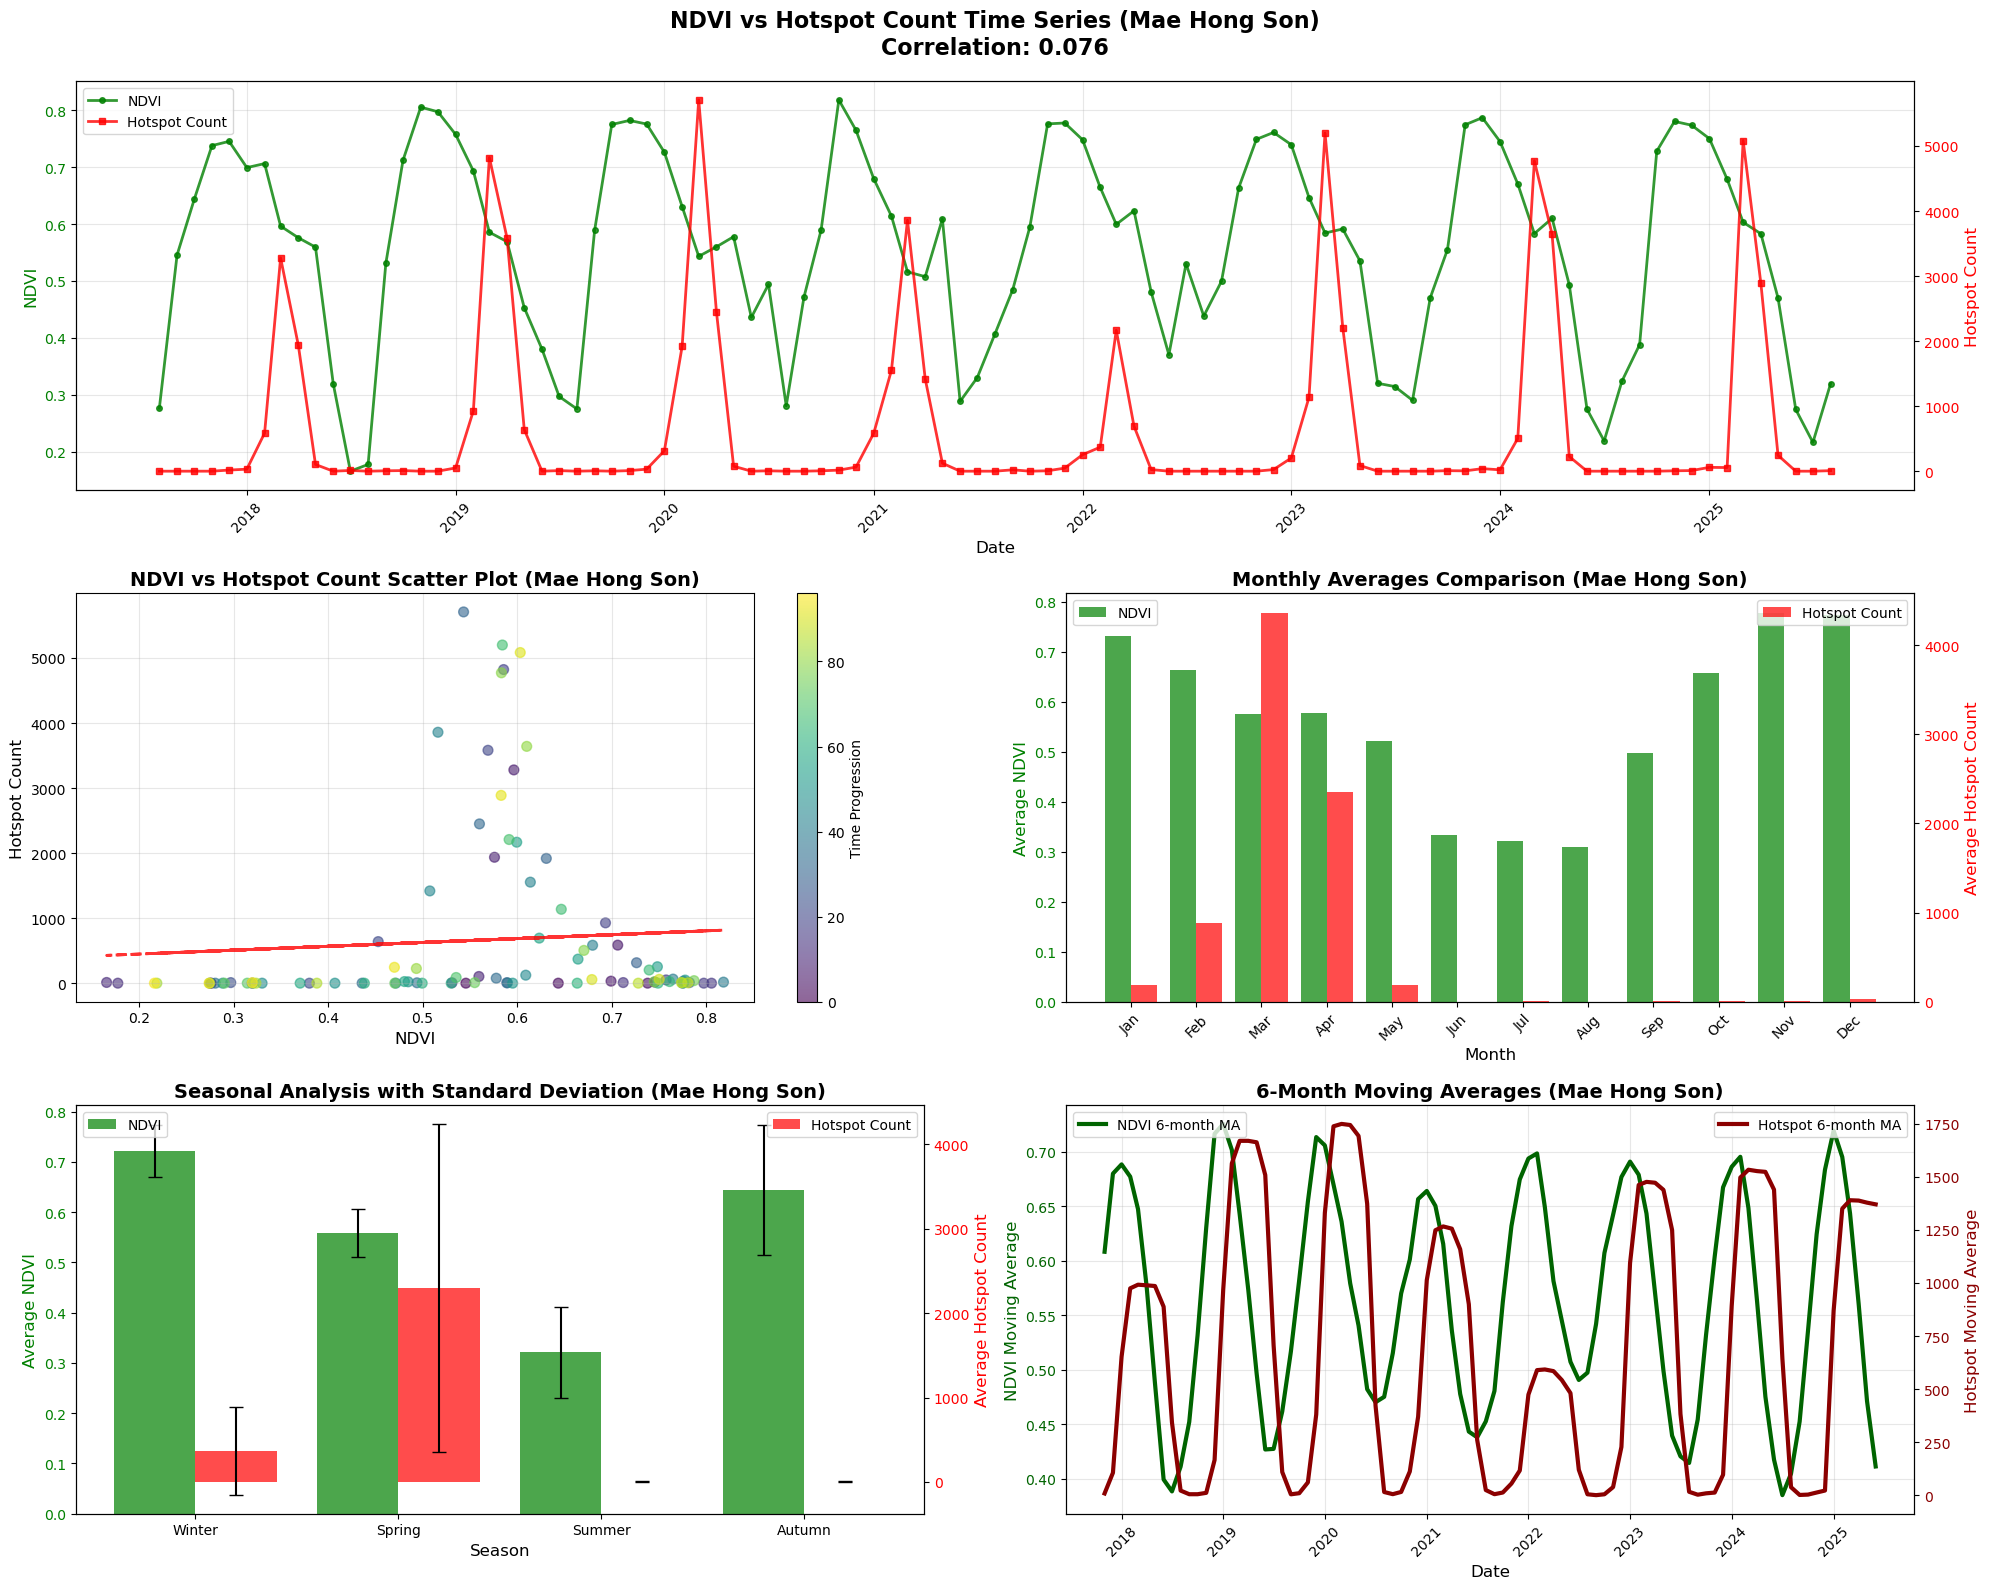


‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏±‡∏°‡∏û‡∏±‡∏ô‡∏ò‡πå NDVI vs Hotspot Count
Pearson Correlation: 0.0757

Lag Correlation Analysis:
NDVI vs Hotspot (lag 1 months): -0.0281
NDVI vs Hotspot (lag 2 months): -0.2710
NDVI vs Hotspot (lag 3 months): -0.5942
NDVI vs Hotspot (lag 4 months): -0.6634
NDVI vs Hotspot (lag 5 months): -0.5167
NDVI vs Hotspot (lag 6 months): -0.0894

Seasonal Correlations:
Winter: -0.8156
Spring: 0.3884
Summer: -0.1264
Autumn: 0.0893
‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü Yearly Comparison: Mae Hong Son_yearly_comparison_analysis.png


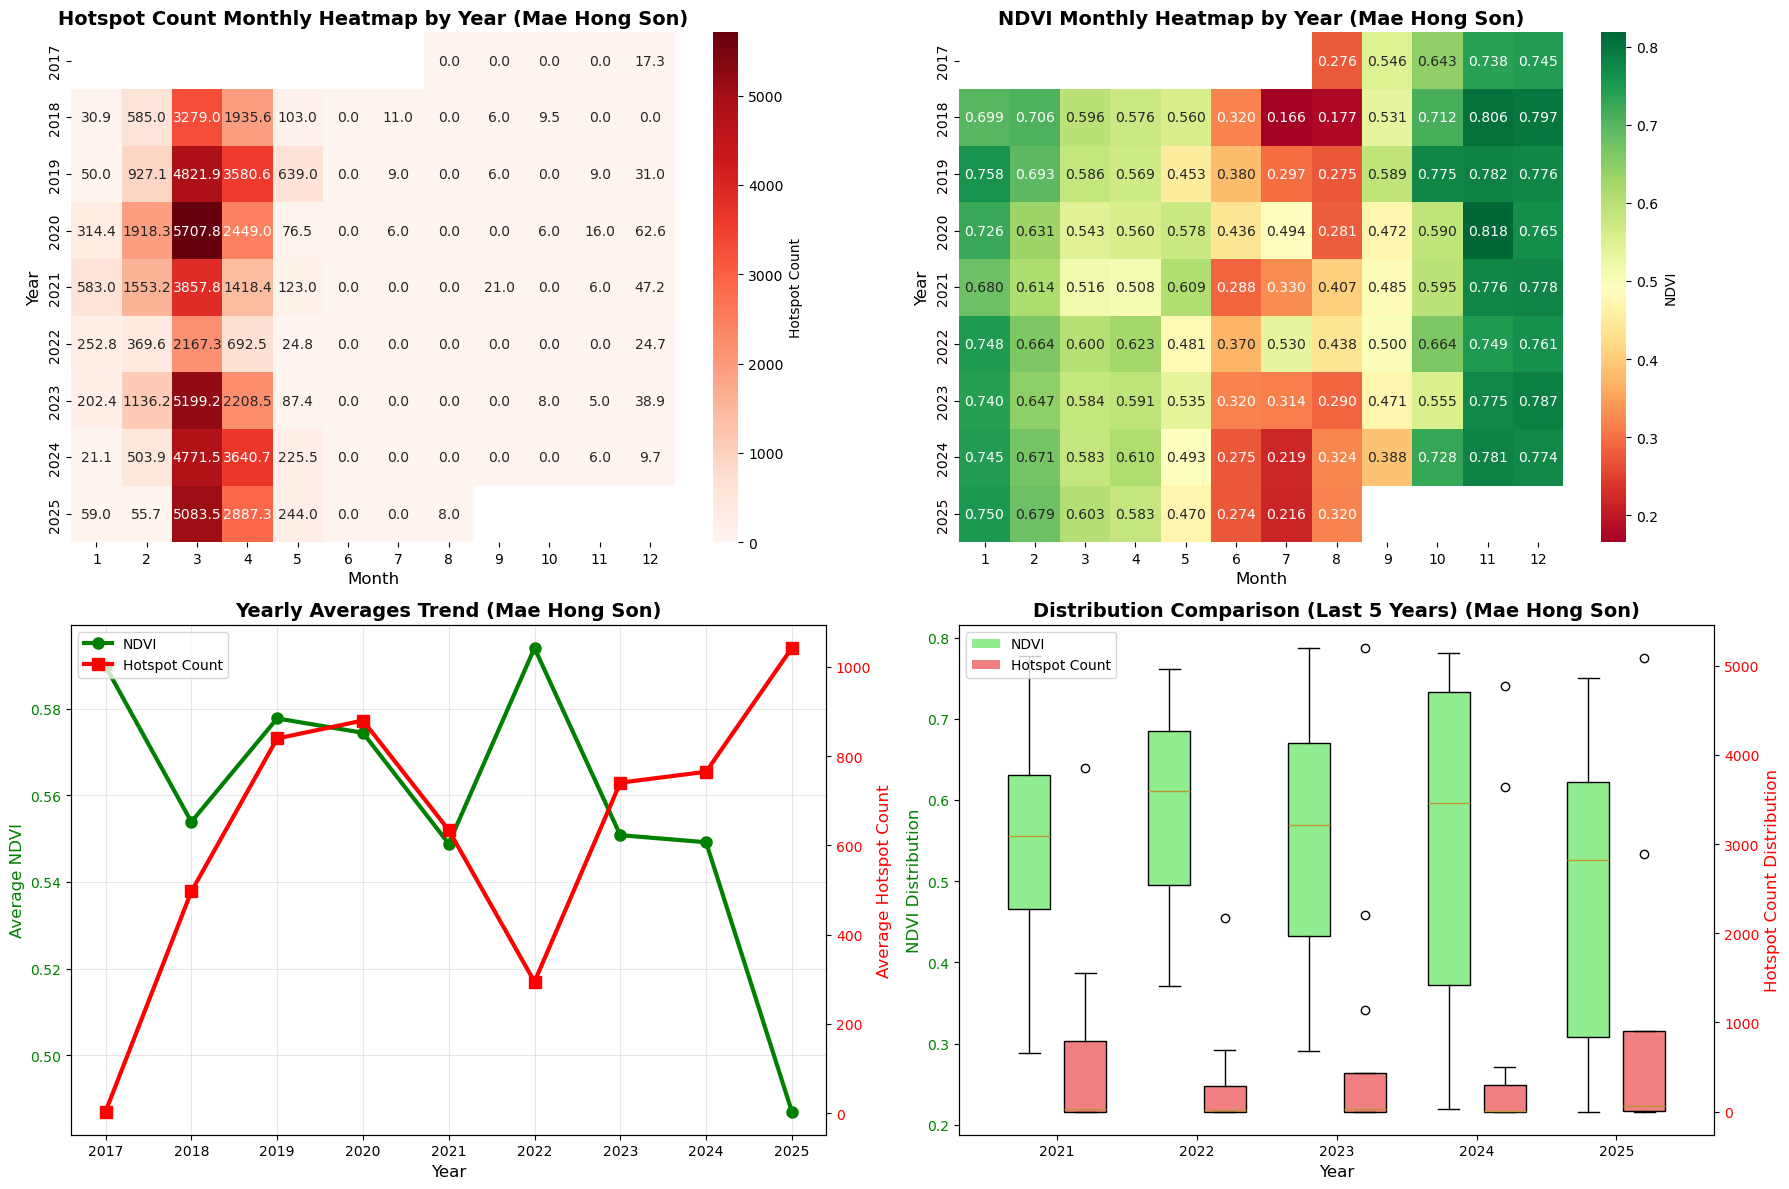


COMPREHENSIVE ANALYSIS REPORT: NDVI vs HOTSPOT COUNT

1. BASIC STATISTICS
----------------------------------------
            NDVI  hotspot_count
count  97.000000      97.000000
mean    0.559095     661.343965
std     0.174767    1373.108944
min     0.165630       0.000000
25%     0.452979       0.000000
50%     0.584322      11.000000
75%     0.712182     369.647064
max     0.818280    5707.799805

2. CORRELATION ANALYSIS
----------------------------------------
Correlation Matrix:
                   NDVI  hotspot_count     month      year
NDVI           1.000000       0.075679  0.063706 -0.087849
hotspot_count  0.075679       1.000000 -0.462826  0.081689
month          0.063706      -0.462826  1.000000 -0.170163
year          -0.087849       0.081689 -0.170163  1.000000

Pearson Correlation Coefficient: 0.0757
P-value: 0.4613
Statistical Significance: No (Œ± = 0.05)

3. SEASONAL ANALYSIS (SEA Climate)
----------------------------------------
Seasonal Statistics (SEA Climate):
     

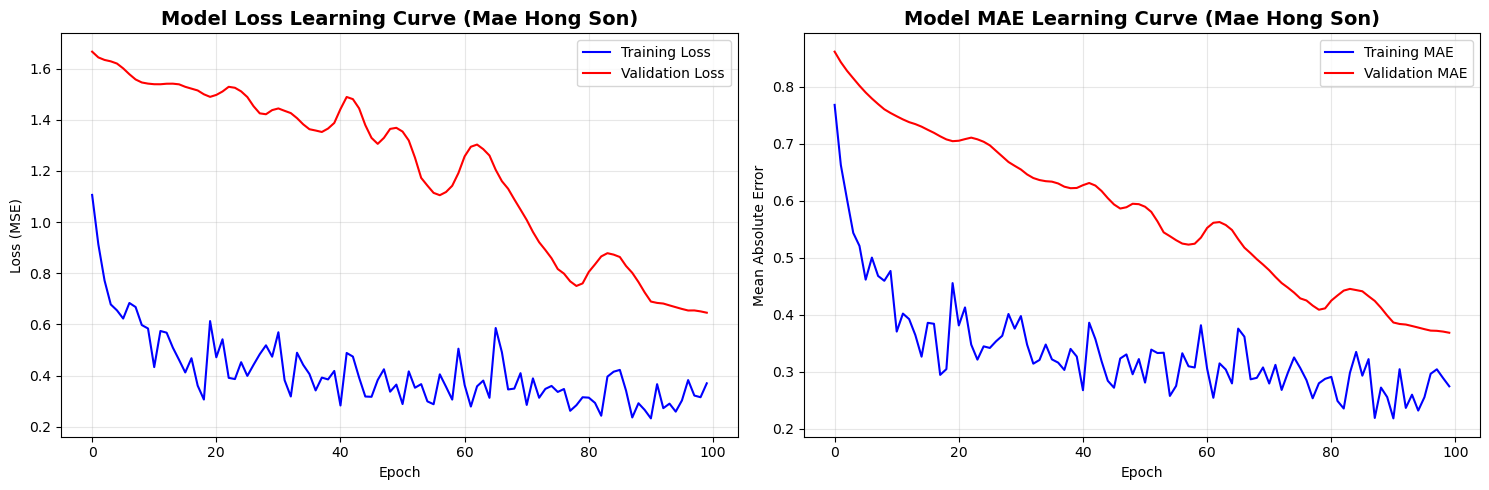

‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü Learning Curve: learning_curve.png

‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏î‡∏≥‡πÄ‡∏ô‡∏¥‡∏ô‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏°...
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 256ms/step
‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô LSTM (‡πÄ‡∏ö‡∏∑‡πâ‡∏≠‡∏á‡∏ï‡πâ‡∏ô):
LSTM - RMSE: 979.4508, MAE: 503.3584, R¬≤: 0.6653

‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏°‡∏Å‡∏±‡∏ö Baseline Models...
‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏° (Comprehensive Model Evaluation)

1. ‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Baseline Models
--------------------------------------------------
‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Seasonal Na√Øve...
‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Na√Øve with Drift...
‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Moving Average...
‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Exponential Smoothing...
ETS model ‡∏•‡πâ‡∏°‡πÄ‡∏´‡∏•‡∏ß: 'HoltWinters

/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/si

‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô Auto-ARIMA...
pmdarima ‡πÑ‡∏°‡πà‡∏û‡∏£‡πâ‡∏≠‡∏°‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô ‡∏Ç‡πâ‡∏≤‡∏° Auto-ARIMA model
‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô LSTM...

‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ú‡∏ô‡∏†‡∏π‡∏°‡∏¥‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡πÇ‡∏°‡πÄ‡∏î‡∏•...


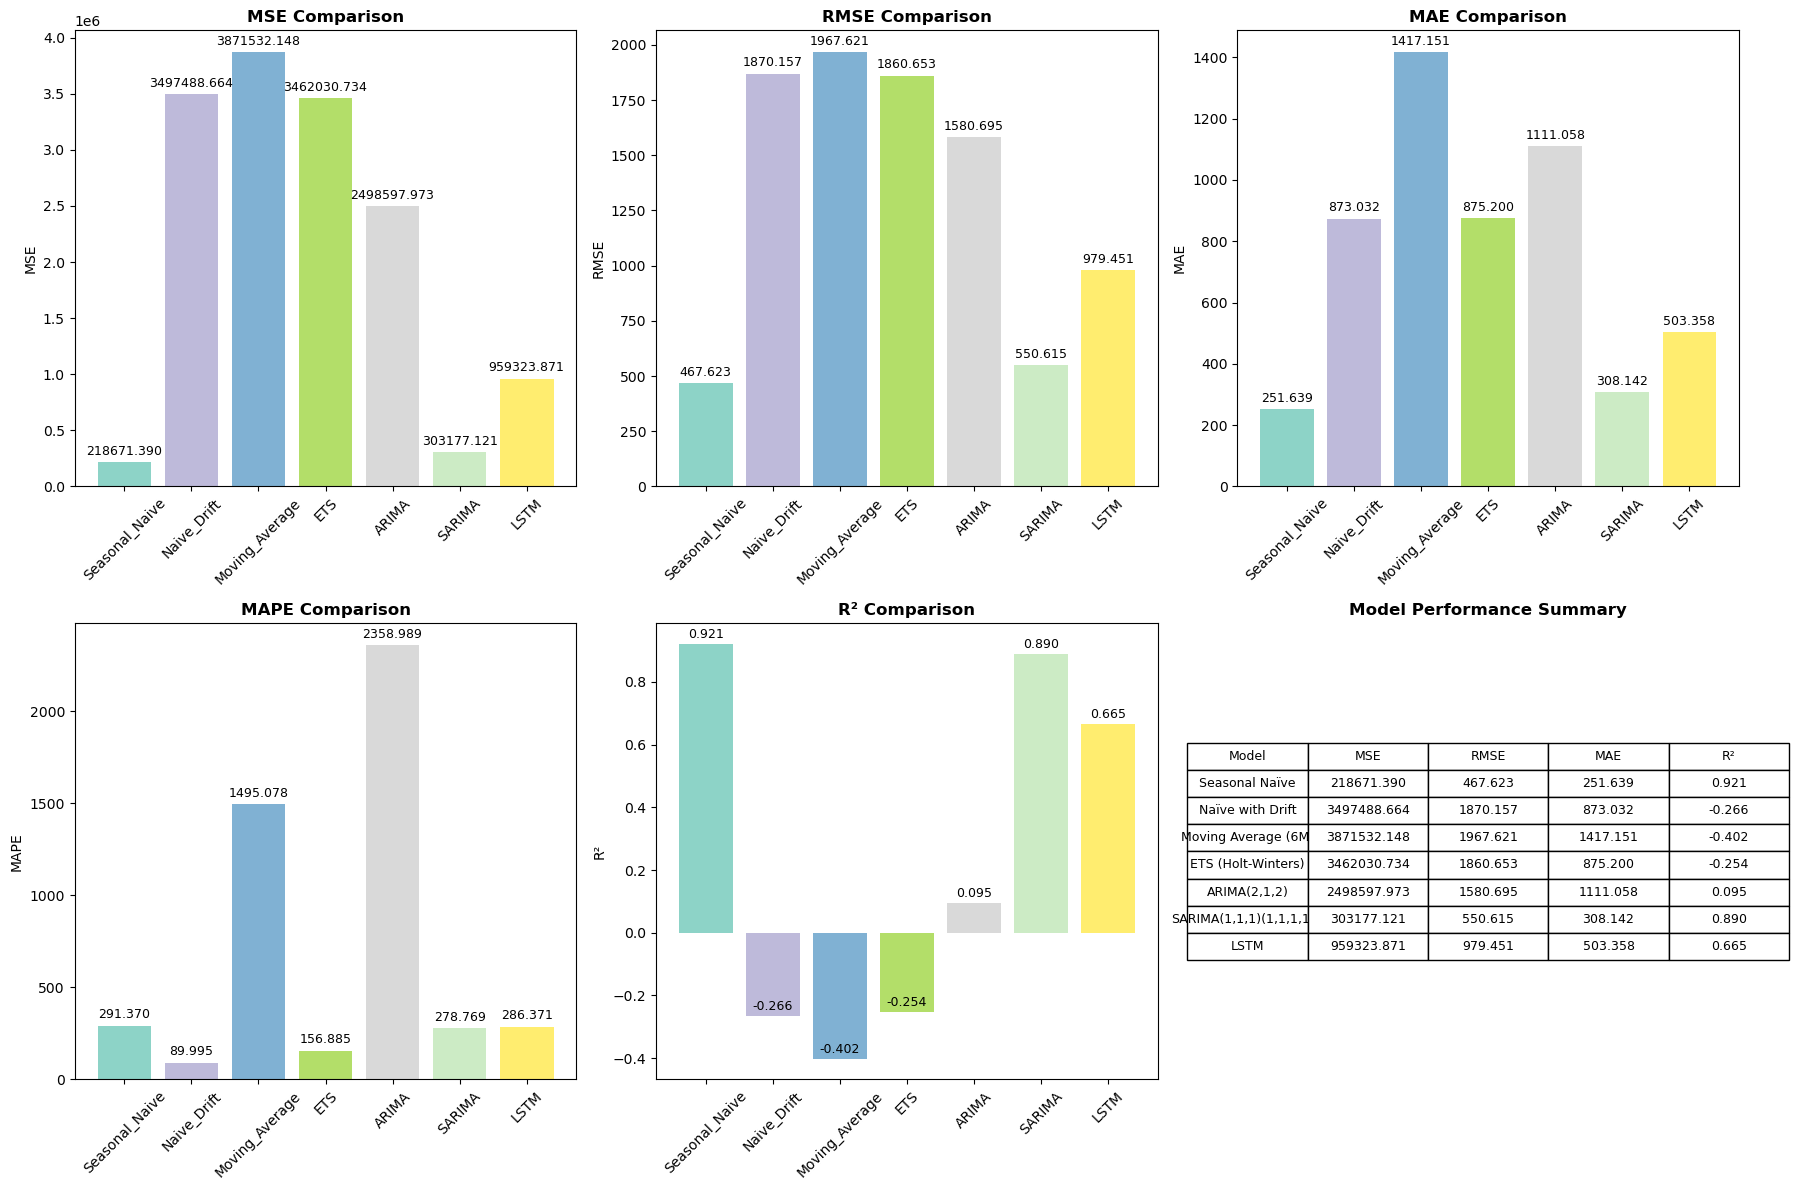

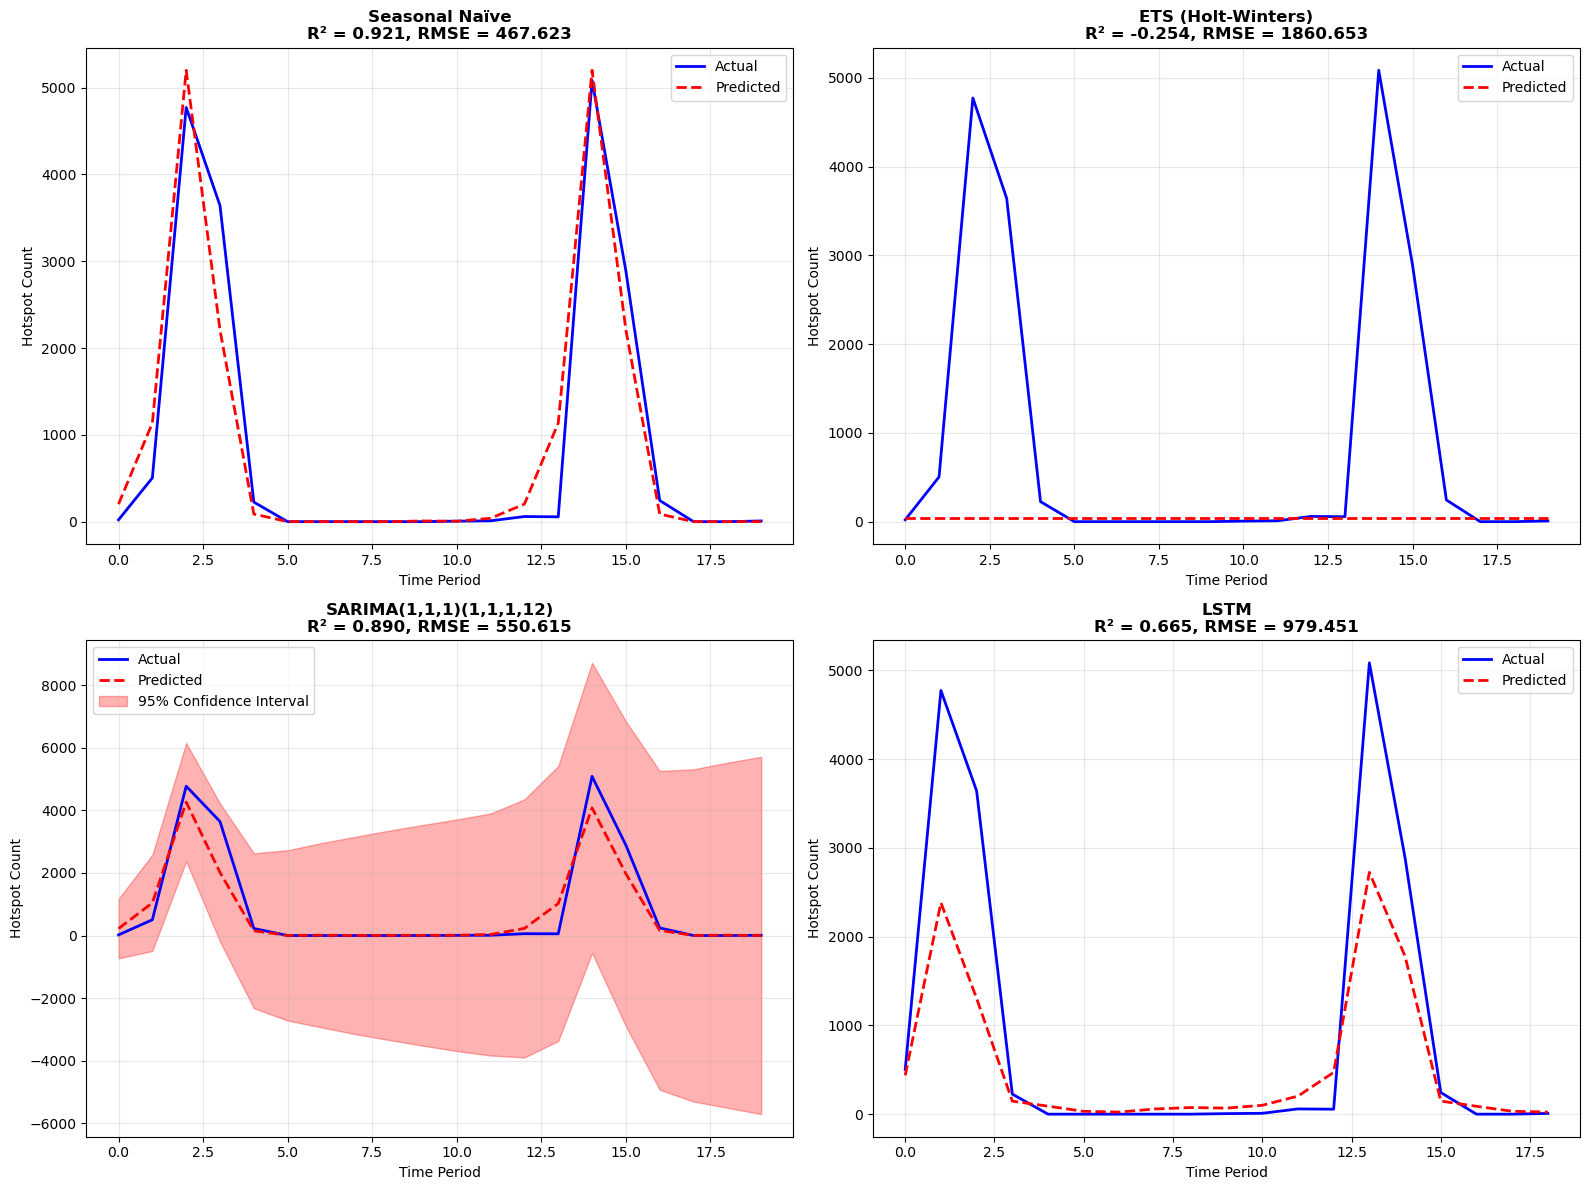


‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÇ‡∏°‡πÄ‡∏î‡∏• (Model Evaluation Summary)
Rank Model                MSE        RMSE       MAE        MAPE       R¬≤        
--------------------------------------------------------------------------------
1    Seasonal Na√Øve       218671.3902 467.6231   251.6390   291.37%    0.9208    
2    SARIMA(1,1,1)(1,1,1,12) 303177.1206 550.6152   308.1421   278.77%    0.8902    
3    LSTM                 959323.8715 979.4508   503.3584   286.37%    0.6653    
4    ARIMA(2,1,2)         2498597.9735 1580.6954  1111.0582  2358.99%   0.0952    
5    ETS (Holt-Winters)   3462030.7344 1860.6533  875.1996   156.88%    -0.2536   
6    Na√Øve with Drift     3497488.6642 1870.1574  873.0316   90.00%     -0.2665   
7    Moving Average (6M)  3871532.1485 1967.6209  1417.1507  1495.08%   -0.4019   

üèÜ ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡∏î‡∏µ‡∏ó‡∏µ‡πà‡∏™‡∏∏‡∏î (‡∏ï‡∏≤‡∏° RMSE): Seasonal Na√Øve
üìä ‡∏≠‡∏±‡∏ô‡∏î‡∏±‡∏ö‡∏Ç‡∏≠‡∏á LSTM: 3 ‡∏à‡∏≤‡∏Å 7 ‡πÇ‡∏°‡πÄ‡∏î‡∏•
‚ö†Ô

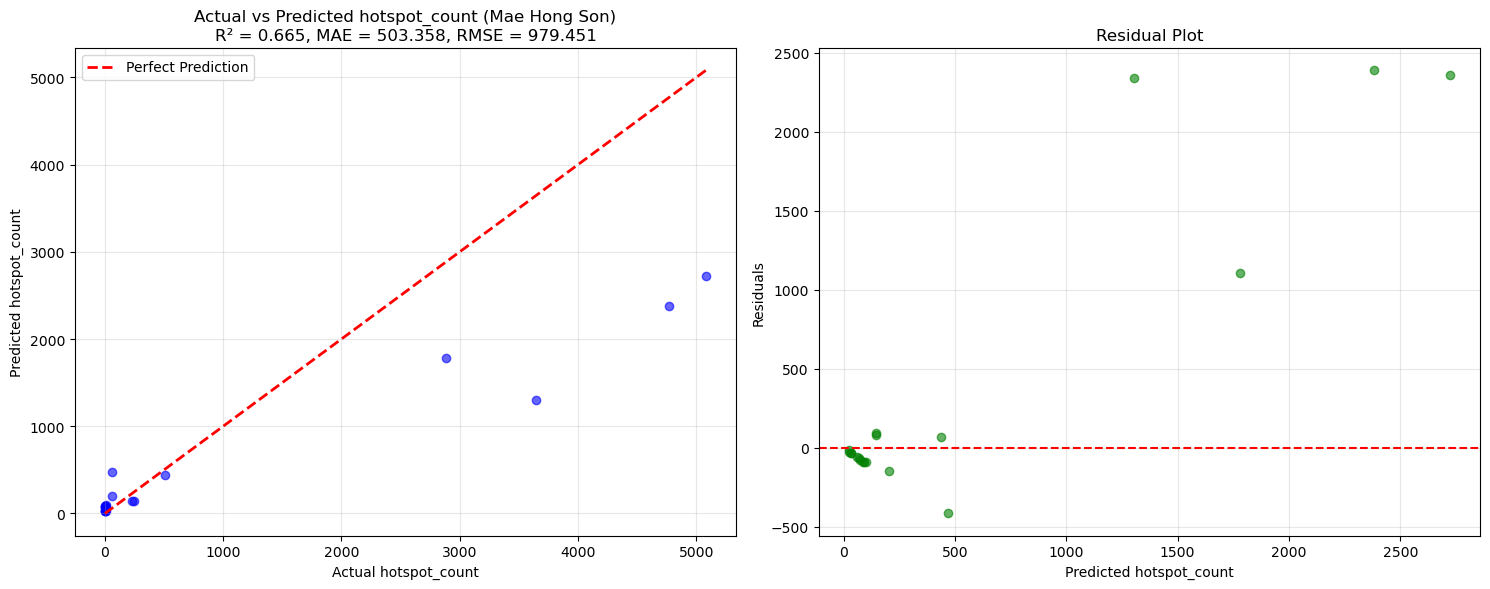

‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü Actual vs Predicted: actual_vs_predicted.png

‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤...
‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÄ‡∏™‡∏£‡πá‡∏à‡∏™‡∏°‡∏ö‡∏π‡∏£‡∏ì‡πå!

‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏î‡∏ä‡πà‡∏ß‡∏á‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏±‡πà‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢...
‡∏ä‡πà‡∏ß‡∏á‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏±‡πà‡∏ô 80%: ¬±1154.7
‡∏ä‡πà‡∏ß‡∏á‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏±‡πà‡∏ô 95%: ¬±1765.3

‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢...

‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ HOTSPOT COUNT ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
      Date     Month  Year  Predicted_hotspot_count  Risk_Level Season
2025-09-01 September  2025                     24.0    Low Risk Summer
2025-10-01   October  2025                     57.0   High Risk Summer
2025-11-01  November  2025                    102.0   High Risk Summer
2025-12-01  Dece

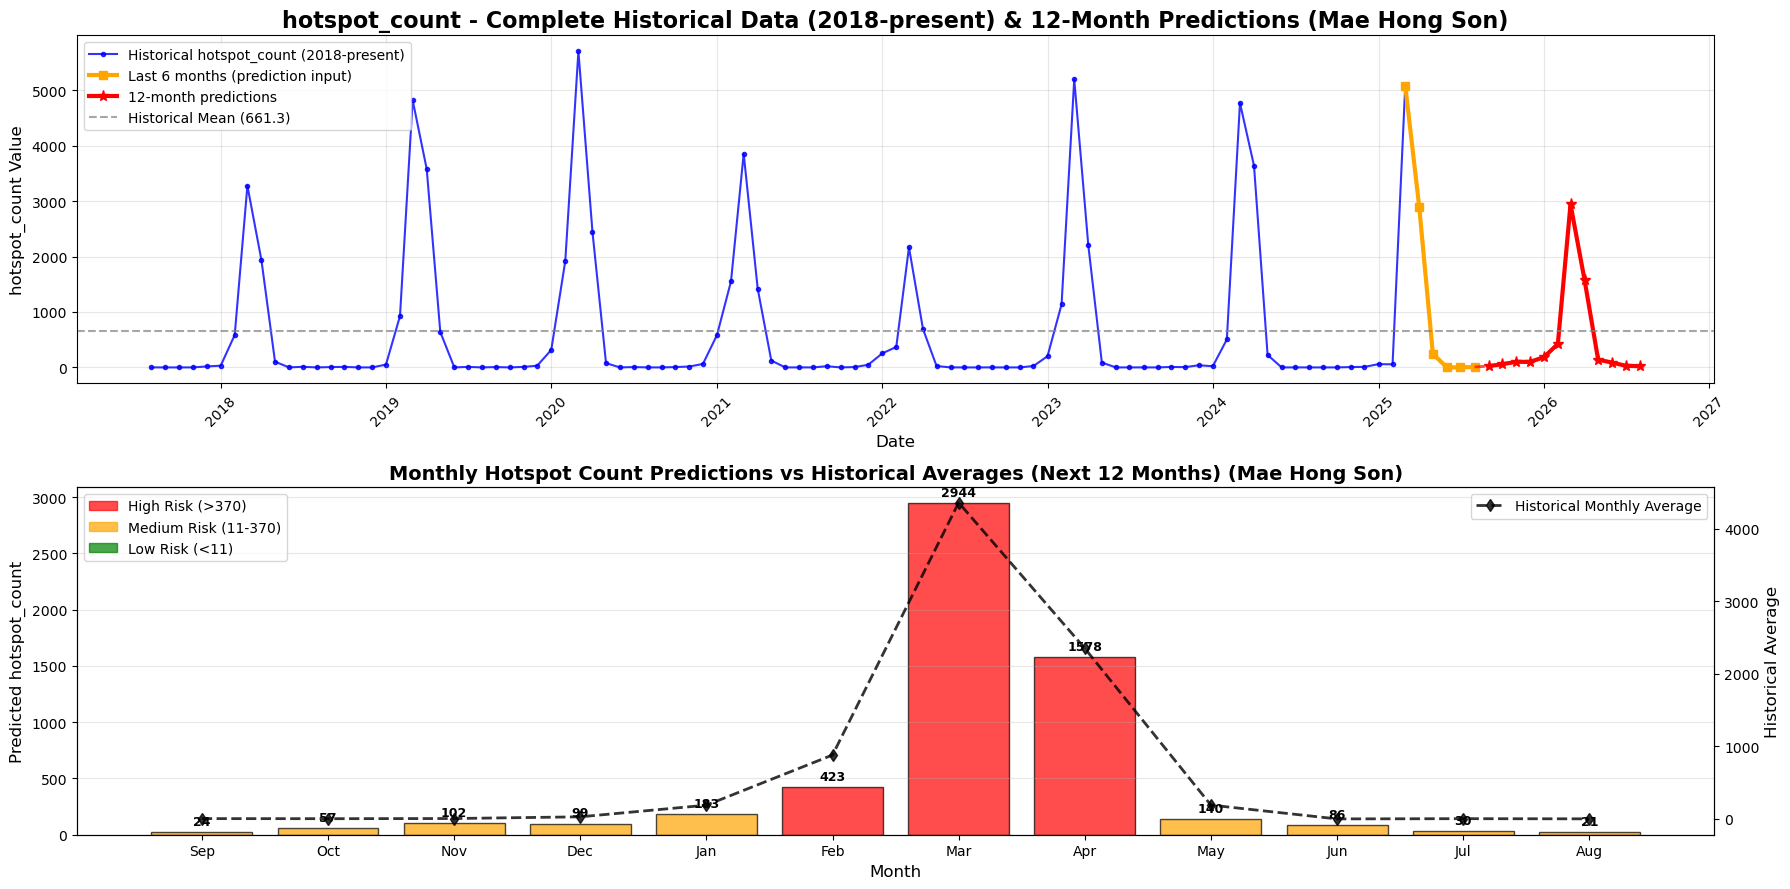

‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô: Mae Hong Son_12_month_prediction.png

‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Å‡∏±‡∏ö‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï:
Sep: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 24, ‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï 4.1, ‡∏ï‡πà‡∏≤‡∏á +19.4 (+470.5%) ‚Üë ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô
Oct: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 57, ‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï 2.9, ‡∏ï‡πà‡∏≤‡∏á +53.9 (+1838.4%) ‚Üë ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô
Nov: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 102, ‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï 5.2, ‡∏ï‡πà‡∏≤‡∏á +96.3 (+1835.1%) ‚Üë ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô
Dec: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 99, ‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï 28.9, ‡∏ï‡πà‡∏≤‡∏á +70.1 (+242.4%) ‚Üë ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô
Jan: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 183, ‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï 189.2, ‡∏ï‡πà‡∏≤‡∏á -6.6 (-3.5%) ‚Üì ‡∏•‡∏î‡∏•‡∏á
Feb: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 423, ‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÉ‡∏ô‡∏≠‡∏î‡∏µ‡∏ï 881.1, ‡∏ï‡πà‡∏≤‡∏á -458.0 (-52.0%) ‚Üì ‡∏•‡∏î‡∏•‡∏á
Mar: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 2944, ‡π

In [4]:
    
# Updated main function to use temperature filtering
def main():
    print("‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡πÅ‡∏•‡∏∞‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ HOTSPOT COUNT ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤ (‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á T21)")
    print("="*80)

    # ‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡∏ä‡πà‡∏ß‡∏á‡πÄ‡∏ß‡∏•‡∏≤‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
    start_date = '2017-08-01'
    end_date = '2025-08-31'
    
    # ‡∏û‡∏≤‡∏£‡∏≤‡∏°‡∏¥‡πÄ‡∏ï‡∏≠‡∏£‡πå‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á hotspot 300-310k, 310-320k, >320k 
    TEMP_MIN = 300  # Kelvin - ‡∏õ‡∏£‡∏±‡∏ö‡πÑ‡∏î‡πâ‡∏ï‡∏≤‡∏°‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£
    TEMP_MAX = 310  # Kelvin - ‡∏õ‡∏£‡∏±‡∏ö‡πÑ‡∏î‡πâ‡∏ï‡∏≤‡∏°‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£
    USE_ALL_HOTSPOTS = True  # True = ‡πÉ‡∏ä‡πâ T21 > 0, False = ‡πÉ‡∏ä‡πâ‡∏ä‡πà‡∏ß‡∏á‡∏≠‡∏∏‡∏ì‡∏´‡∏†‡∏π‡∏°‡∏¥
    
    print(f"‡∏Å‡∏≤‡∏£‡∏ï‡∏±‡πâ‡∏á‡∏Ñ‡πà‡∏≤‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á hotspot:")
    if USE_ALL_HOTSPOTS:
        print("- ‡πÉ‡∏ä‡πâ‡∏ó‡∏∏‡∏Å‡∏à‡∏∏‡∏î‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô (T21 > 0)")
    else:
        print(f"- ‡πÉ‡∏ä‡πâ‡∏ä‡πà‡∏ß‡∏á‡∏≠‡∏∏‡∏ì‡∏´‡∏†‡∏π‡∏°‡∏¥: {TEMP_MIN}K ‚â§ T21 < {TEMP_MAX}K")
    print()

    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏à‡∏≤‡∏Å Google Earth Engine...")
    ndvi_data = get_monthly_ndvi(start_date, end_date, study_area)

    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• Hotspot ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á T21...")
    hotspot_data = get_monthly_hotspots(
        start_date, end_date, study_area, 
        temp_min=TEMP_MIN, 
        temp_max=TEMP_MAX,
        all_hotspots=USE_ALL_HOTSPOTS
    )

    if ndvi_data is not None and hotspot_data is not None:
        print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI: {ndvi_data.size().getInfo()}")
        print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• Hotspot: {hotspot_data.size().getInfo()}")

        print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏ß‡∏°...")
        dataset = create_monthly_dataset_with_filtered_hotspots(ndvi_data, hotspot_data, study_area)

        if dataset is not None:
            print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡πÅ‡∏õ‡∏•‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô DataFrame...")
            df = fc_to_df(dataset)
            print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÉ‡∏ô DataFrame: {len(df)} ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô")

            if not df.empty and len(df) > 24:
                print("‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•:")
                print(df.head(10))
                print(f"\n‡∏ä‡πà‡∏ß‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•: {df['date'].min()} ‡∏ñ‡∏∂‡∏á {df['date'].max()}")
                print(f"‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏û‡∏∑‡πâ‡∏ô‡∏ê‡∏≤‡∏ô hotspot count:")
                print(f"- ‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {df['hotspot_count'].mean():.2f}")
                print(f"- ‡∏Ñ‡πà‡∏≤‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î: {df['hotspot_count'].max():.0f}")
                print(f"- ‡∏Ñ‡πà‡∏≤‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î: {df['hotspot_count'].min():.0f}")
                print(f"- ‡∏™‡πà‡∏ß‡∏ô‡πÄ‡∏ö‡∏µ‡∏¢‡∏á‡πÄ‡∏ö‡∏ô‡∏°‡∏≤‡∏ï‡∏£‡∏ê‡∏≤‡∏ô: {df['hotspot_count'].std():.2f}")

                # ‡∏™‡πà‡∏ß‡∏ô‡πÉ‡∏´‡∏°‡πà: ‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå Time Series ‡∏Ç‡∏±‡πâ‡∏ô‡∏™‡∏π‡∏á
                print("\n" + "="*60)
                print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå Time Series ‡∏Ç‡∏±‡πâ‡∏ô‡∏™‡∏π‡∏á...")
                print("="*60)

                # 1. Comprehensive time series analysis
                plot_ndvi_hotspot_time_series(df)

                # 2. Yearly comparison analysis  
                plot_yearly_comparison(df)

                # 3. Statistical analysis report
                analysis_results = create_comprehensive_analysis_report(df)

                # ‡∏™‡πà‡∏ß‡∏ô‡πÄ‡∏î‡∏¥‡∏°: ‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á LSTM (‡∏õ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∏‡∏á)
                print("\n" + "="*60)
                print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏î‡∏≥‡πÄ‡∏ô‡∏¥‡∏ô‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á‡πÅ‡∏•‡∏∞‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢...")
                print("="*60)
                
                print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á...")
                try:
                    X, y, scaler_x, scaler_y, df_cleaned = prepare_monthly_training_data(
                        df, sequence_length=6, target_column='hotspot_count'
                    )
                    print(f"‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°: X.shape = {X.shape}, y.shape = {y.shape}")

                    # ‡πÅ‡∏ö‡πà‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô
                    split_idx = int(len(X) * 0.8)
                    X_train, X_test = X[:split_idx], X[split_idx:]
                    y_train, y_test = y[:split_idx], y[split_idx:]

                    print(f"‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏≠‡∏ô: {X_train.shape}, ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏î‡∏™‡∏≠‡∏ö: {X_test.shape}")

                    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏•‡∏∞‡∏™‡∏≠‡∏ô‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á
                    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á LSTM...")
                    model = create_monthly_lstm_model(X_train.shape[1], X_train.shape[2])

                    if model is None:
                        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á‡πÑ‡∏î‡πâ ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏Å‡∏≤‡∏£‡∏ï‡∏¥‡∏î‡∏ï‡∏±‡πâ‡∏á TensorFlow")
                        return

                    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏≠‡∏ô‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á...")

                    # ‡πÄ‡∏û‡∏¥‡πà‡∏° callbacks ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏™‡∏≠‡∏ô‡∏ó‡∏µ‡πà‡∏î‡∏µ‡∏Ç‡∏∂‡πâ‡∏ô
                    try:
                        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

                        early_stopping = EarlyStopping(
                            monitor='val_loss',
                            patience=15,
                            restore_best_weights=True,
                            verbose=1
                        )

                        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss',
                            factor=0.5,
                            patience=10,
                            min_lr=1e-7,
                            verbose=1
                        )

                        callbacks = [early_stopping, reduce_lr]
                    except ImportError:
                        callbacks = []

                    history = model.fit(
                        X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_test, y_test) if len(X_test) > 0 else None,
                        callbacks=callbacks,
                        verbose=0
                    )

                    # ‡∏™‡πà‡∏ß‡∏ô‡πÄ‡∏î‡∏¥‡∏°: ‡∏Å‡∏£‡∏≤‡∏ü Learning Curve
                    print("\n‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü Learning Curve...")
                    plot_learning_curve(history)

                    # ‡∏™‡πà‡∏ß‡∏ô‡πÉ‡∏´‡∏°‡πà: ‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏°
                    if len(X_test) > 0:
                        print("\n" + "="*60)
                        print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏î‡∏≥‡πÄ‡∏ô‡∏¥‡∏ô‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏°...")
                        print("="*60)
                        
                        # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏î‡πâ‡∏ß‡∏¢ LSTM
                        y_pred = model.predict(X_test)
                        y_pred_rescaled = scaler_y.inverse_transform(y_pred).flatten()
                        y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

                        print("‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô LSTM (‡πÄ‡∏ö‡∏∑‡πâ‡∏≠‡∏á‡∏ï‡πâ‡∏ô):")
                        lstm_mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
                        lstm_rmse = np.sqrt(lstm_mse)
                        lstm_mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
                        lstm_r2 = r2_score(y_test_rescaled, y_pred_rescaled)
                        
                        print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, R¬≤: {lstm_r2:.4f}")

                        # ‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏°‡πÉ‡∏´‡∏°‡πà
                        print("\n‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏°‡∏Å‡∏±‡∏ö Baseline Models...")
                        
                        # ‡πÄ‡∏£‡∏µ‡∏¢‡∏Å‡πÉ‡∏ä‡πâ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏≠‡∏ö‡∏Ñ‡∏•‡∏∏‡∏°
                        results, prediction_intervals = comprehensive_model_evaluation(
                            df=df_cleaned, 
                            lstm_predictions=y_pred_rescaled,
                            lstm_actuals=y_test_rescaled,
                            target_column='hotspot_count',
                            siteName=siteName
                        )

                        # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ú‡∏ô‡∏†‡∏π‡∏°‡∏¥‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö
                        print("\n‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ú‡∏ô‡∏†‡∏π‡∏°‡∏¥‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡πÇ‡∏°‡πÄ‡∏î‡∏•...")
                        plot_model_comparison_comprehensive(results, prediction_intervals, siteName)

                        # ‡∏û‡∏¥‡∏°‡∏û‡πå‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•
                        print_model_summary(results)

                        # ‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡πÄ‡∏î‡∏¥‡∏°
                        print("\n‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü Actual vs Predicted...")
                        plot_actual_vs_predicted(
                            y_test_rescaled,
                            y_pred_rescaled,
                            target_column='hotspot_count'
                        )

                    # ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤ (‡∏õ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∏‡∏á)
                    print("\n" + "="*60)
                    print("‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤...")
                    print("="*60)
                    
                    last_sequence = X[-1:]
                    predictions, prediction_dates = predict_next_12_months(
                        model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6
                    )

                    print("‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÄ‡∏™‡∏£‡πá‡∏à‡∏™‡∏°‡∏ö‡∏π‡∏£‡∏ì‡πå!")

                    # ‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á Prediction Intervals ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
                    print("\n‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏î‡∏ä‡πà‡∏ß‡∏á‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏±‡πà‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢...")
                    
                    # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏î prediction intervals ‡πÅ‡∏ö‡∏ö‡∏á‡πà‡∏≤‡∏¢ (‡∏à‡∏≤‡∏Å residuals)
                    if len(X_test) > 0:
                        residuals = y_test_rescaled - y_pred_rescaled
                        residual_std = np.std(residuals)
                        
                        # ‡∏™‡∏£‡πâ‡∏≤‡∏á confidence intervals
                        confidence_80 = 1.282 * residual_std  # 80% CI
                        confidence_95 = 1.96 * residual_std   # 95% CI
                        
                        prediction_intervals_12m = {
                            '80%': {
                                'lower': np.array(predictions) - confidence_80,
                                'upper': np.array(predictions) + confidence_80
                            },
                            '95%': {
                                'lower': np.array(predictions) - confidence_95,
                                'upper': np.array(predictions) + confidence_95
                            }
                        }
                        
                        print(f"‡∏ä‡πà‡∏ß‡∏á‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏±‡πà‡∏ô 80%: ¬±{confidence_80:.1f}")
                        print(f"‡∏ä‡πà‡∏ß‡∏á‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏±‡πà‡∏ô 95%: ¬±{confidence_95:.1f}")
                    else:
                        prediction_intervals_12m = {}

                    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏™‡∏£‡∏∏‡∏õ
                    print("\n‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢...")
                    pred_summary_df = create_prediction_summary_table(
                        predictions, prediction_dates, target_column='hotspot_count'
                    )

                    # ================================
                    # ‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô (‡∏õ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∏‡∏á)
                    # ================================
                    print("\n‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô...")
                    plot_12_month_prediction(df_cleaned, predictions, prediction_dates, target_column='hotspot_count')

                    # ================================
                    # ‡∏™‡∏£‡∏∏‡∏õ‡πÑ‡∏ü‡∏•‡πå‡∏ó‡∏µ‡πà‡∏™‡∏£‡πâ‡∏≤‡∏á
                    # ================================
                    print("\n" + "="*80)
                    print("‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡πÅ‡∏•‡∏∞‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ HOTSPOT COUNT ‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡πÄ‡∏™‡∏£‡πá‡∏à‡∏™‡∏°‡∏ö‡∏π‡∏£‡∏ì‡πå!")
                    print("="*80)
                    print("‡πÑ‡∏ü‡∏•‡πå‡∏ó‡∏µ‡πà‡∏™‡∏£‡πâ‡∏≤‡∏á:")
                    print("üìä ‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå:")
                    print("  - ndvi_hotspot_time_series_analysis.png: ‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå time series ‡∏Ç‡∏±‡πâ‡∏ô‡∏™‡∏π‡∏á")
                    print("  - yearly_comparison_analysis.png: ‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏£‡∏≤‡∏¢‡∏õ‡∏µ")
                    print("  - ndvi_hotspot_analysis_report.txt: ‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå")
                    print("üìà ‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏°‡∏¥‡∏ô‡πÇ‡∏°‡πÄ‡∏î‡∏•:")
                    print("  - model_metrics_comparison.png: ‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö metrics ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ï‡πà‡∏≤‡∏á‡πÜ")
                    print("  - predictions_with_intervals.png: ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏ä‡πà‡∏ß‡∏á‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏±‡πà‡∏ô")
                    print("  - learning_curve.png: ‡∏Å‡∏£‡∏≤‡∏ü Learning Curve")
                    print("  - actual_vs_predicted.png: ‡∏Å‡∏£‡∏≤‡∏ü Actual vs Predicted")
                    print("üîÆ ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢:")
                    print("  - 12_month_prediction.png: ‡∏Å‡∏£‡∏≤‡∏ü‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô")
                    print("  - 12_month_hotspot_predictions.csv: ‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢")
                    print(f"\nüéØ ‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á T21: {TEMP_MIN}K ‚â§ T21 < {TEMP_MAX}K" if not USE_ALL_HOTSPOTS else "\nüéØ ‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏≠‡∏á T21: ‡∏ó‡∏∏‡∏Å‡∏à‡∏∏‡∏î‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô (T21 > 0)")
                    print("üéØ ‡∏™‡∏≥‡∏Ñ‡∏±‡∏ç: ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏≠‡∏±‡∏ô‡∏î‡∏±‡∏ö‡∏Ç‡∏≠‡∏á LSTM ‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡πÇ‡∏°‡πÄ‡∏î‡∏•")
                    print("   - ‡∏´‡∏≤‡∏Å LSTM ‡∏≠‡∏±‡∏ô‡∏î‡∏±‡∏ö‡∏ï‡πâ‡∏ô‡πÜ: ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏°‡∏µ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏î‡∏µ")
                    print("   - ‡∏´‡∏≤‡∏Å LSTM ‡∏≠‡∏±‡∏ô‡∏î‡∏±‡∏ö‡∏ó‡πâ‡∏≤‡∏¢‡πÜ: ‡∏Ñ‡∏ß‡∏£‡∏õ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∏‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏´‡∏£‡∏∑‡∏≠‡πÉ‡∏ä‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏á‡πà‡∏≤‡∏¢‡∏Å‡∏ß‡πà‡∏≤")

                except Exception as e:
                    print(f"‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•: {e}")
                    import traceback
                    print("‡∏£‡∏≤‡∏¢‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î:")
                    traceback.print_exc()
            else:
                print("‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÑ‡∏°‡πà‡πÄ‡∏û‡∏µ‡∏¢‡∏á‡∏û‡∏≠‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏™‡∏£‡πâ‡∏≤‡∏á‡πÅ‡∏ö‡∏ö‡∏à‡∏≥‡∏•‡∏≠‡∏á (‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ 24 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô)")
        else:
            print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÑ‡∏î‡πâ")
    else:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• NDVI ‡∏´‡∏£‡∏∑‡∏≠ Hotspot ‡πÑ‡∏î‡πâ")



if __name__ == "__main__":
    main()